<a href="https://colab.research.google.com/github/AdamCorbinFAUPhD/Melanoma-experiments/blob/main/2023_02_11/validate_all_models/melanoma_competiton_aug_resnet_effnet_lb_0_91.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


# 1. Introduction

This notebook will cover exploring melanoma classification using the Kaggle melanoma 2020 competition 

Models used:

Datasets used:

Experiments to be saved here: https://github.com/AdamCorbinFAUPhD/Melanoma-experiments



## TODO tasks
- [X] (DONE 1/2/2023) Check to see if the masks are flipped and rotated?
- [X] (DONE 1/3/2023) Create test dataset from [ISIC 2016 task 3](https://challenge.isic-archive.com/landing/2016/39/) skin leasion classificaiton
  - [X] (DONE 1/3/2023) Need to complete Fitzpatric type on ISIC 2016
  - [X] (DONE 1/3/2023) Maybe need to compute masks as well
- [X] (DONE 1/3/2023) Fix the confusion matrix for each skin type
- [X] (DONE 1/3/2023) Create sensitvity and specifity metrics
- [X] (DONE 1/3/2023) Split up melanoma dataset to have a validation dataset
- [X] (DONE 1/4/2023) Retrain wiht new test set
- [X] Revalidate using new validation set
- [X] (DONE 1/3/2023) Create fairness metrics 
  - [X] (DONE 1/3/2023) Statistical parity 
  - [X] (DONE 1/3/2023) Disparate impact 
  - [X] (DONE 1/3/2023) Equalized odds
  - [X] (DONE 1/3/2023) Equal opportunity
  - [X] (DONE 1/3/2023) Predictive rate parity     
  - [X] (DONE 2/10/2023) Absolute Between-ROC Area
- [X] (DONE 2/10/2023) Compute ROC curve
- [X] (DONE 2/10/2023) Test using ResNet50
- [X] Implement CIRCLe regurlization 
- [ ] Get metrics per FST
- [ ] Select 5 melanoma and non-melanoma examples to follow through all of these experiments and to view their grad cam results
- [ ] Possible look at different XAI if time permits


In [1]:
from pathlib import Path

# Constants
use_data_cached = True
generate_masks = False
output_size = 1
num_workers = 2
mask_path = Path("/input/melanoma_masks/results1")
use_regularization = True
regularization_alpha = 0.1


## Installs

In [2]:
!pip install -q efficientnet_pytorch             # Convolutional Neural Net from Google Research

In [3]:
!pip install captum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# only needed if we need to re-generate Fitzpatrick info
!pip install derm-ita
from derm_ita import get_ita, get_kinyanjui_type, get_cropped_center_ita, get_kinyanjui_groh_type

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## imports

In [6]:
# System
import cv2
import os, os.path
from PIL import Image              # from RBG to YCbCr
import gc
import time
import datetime
import zipfile
from pathlib import Path
from enum import Enum
import io

# Basics
import pandas as pd
import numpy as np
import random
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg    # to check images
# %matplotlib inline
from tqdm.notebook import tqdm      # beautiful progression bar

# SKlearn
from sklearn.model_selection import StratifiedKFold, GroupKFold
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, precision_score, recall_score, f1_score, roc_curve
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import CustomObjectScope
from tensorflow.keras.models import load_model

# PyTorch
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch import FloatTensor, LongTensor
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torchsummary import summary
from torchvision import transforms

# Data Augmentation for Image Preprocessing
from albumentations import (ToFloat, Normalize, VerticalFlip, HorizontalFlip, Compose, Resize,
                            RandomBrightnessContrast, HueSaturationValue, Blur, GaussNoise,
                            Rotate, RandomResizedCrop, Cutout, ShiftScaleRotate)
from albumentations.pytorch import ToTensorV2

from efficientnet_pytorch import EfficientNet
from torchvision.models import resnet34, resnet50

# images
import PIL
from PIL import ImageStat
from PIL import Image
from PIL import ImageOps

# XAI
from captum.attr import GuidedGradCam
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget, BinaryClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

import warnings
warnings.filterwarnings("ignore")

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### Set the Seeds 🌱
> For reproducibility

In [8]:
def set_seed(seed = 1234):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device available now:', device)

Device available now: cuda


# 2. Data Preparation 📁📂

> The data we'll work on has a Train and Test .csv files with coresponding .jpg images. Number of data points also increased with other [external sources.](https://www.kaggle.com/nroman/melanoma-external-malignant-256)
<img src='https://i.imgur.com/Z06dlVw.png' width=500>



## 2.1 Read in the data 🔎

### Upload kaggle secrets

In [9]:
!mkdir ~/.kaggle

In [ ]:
from google.colab import files

files.upload()

In [11]:
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [12]:
!ls -l ~/.kaggle

total 4
-rw------- 1 root root 66 Feb 11 09:35 kaggle.json


In [13]:
#!kaggle datasets download -d cdeotte/jpeg-melanoma-256x256

In [14]:
!kaggle datasets download -d andradaolteanu/siim-melanoma-prep-data

 86% 58.0M/67.2M [00:00<00:00, 74.3MB/s]
100% 67.2M/67.2M [00:00<00:00, 72.1MB/s]


In [15]:
!mkdir /input
!mkdir /working

In [ ]:
!unzip siim-melanoma-prep-data -d ../input/siim-melanoma-prep-data

In [17]:
!kaggle datasets download -d nroman/melanoma-external-malignant-256

 99% 1.00G/1.01G [00:10<00:00, 157MB/s]
100% 1.01G/1.01G [00:10<00:00, 106MB/s]


In [18]:
!unzip melanoma-external-malignant-256 -d ../input/melanoma-external-malignant-256

Streaming output truncated to the last 5000 lines.
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8513112.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8513649.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8514170.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8514989.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8515165.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8515281.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8515582.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8515674.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8516181.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8516223.jpg  
  inflating: ../input/melanoma-external-malignant-256/train/train/ISIC_8516516.jpg  
  inflating: .

### Getting data from google drive

In [19]:
# cached dataframe
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/saved_data_2023_01_28_kaggle_melanoma_2020.csv /content/
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/saved_data_2023_02_02_ISIC_2016_test_set.csv /content/


In [20]:
# generated masks
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/kaggle_melanoma_2020_mask_results1_2023_01_28.zip /content/
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/isic_2016_task3_mask_results2_2023_02_02.zip /content/

In [21]:
!unzip kaggle_melanoma_2020_mask_results1_2023_01_28 -d ../input/melanoma_masks
!unzip isic_2016_task3_mask_results2_2023_02_02 -d ../input/isic_2016_masks

Streaming output truncated to the last 5000 lines.
  inflating: ../input/melanoma_masks/results1/ISIC_5997802.png  
  inflating: ../input/melanoma_masks/results1/ISIC_1287173.png  
  inflating: ../input/melanoma_masks/results1/ISIC_5062795.png  
  inflating: ../input/melanoma_masks/results1/ISIC_3946914.png  
  inflating: ../input/melanoma_masks/results1/ISIC_0977333.png  
  inflating: ../input/melanoma_masks/results1/ISIC_8366570.png  
  inflating: ../input/melanoma_masks/results1/ISIC_0053644.png  
  inflating: ../input/melanoma_masks/results1/ISIC_8447658.png  
  inflating: ../input/melanoma_masks/results1/ISIC_6434203.png  
  inflating: ../input/melanoma_masks/results1/ISIC_4004269.png  
  inflating: ../input/melanoma_masks/results1/ISIC_0014255_downsampled.png  
  inflating: ../input/melanoma_masks/results1/ISIC_7473338.png  
  inflating: ../input/melanoma_masks/results1/ISIC_4397755.png  
  inflating: ../input/melanoma_masks/results1/ISIC_2126176.png  
  inflating: ../input/melan

### Get ISIC 2016 Test dataset


In [22]:
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
!wget https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv

--2023-02-11 09:36:17--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.107.20, 54.231.138.41, 54.231.139.233, ...
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.107.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 631625308 (602M) [application/zip]
Saving to: ‘ISBI2016_ISIC_Part3_Training_Data.zip’

ISBI2016_ISIC_Part3 100%[===================>] 602.36M  45.5MB/s    in 14s     

2023-02-11 09:36:31 (44.0 MB/s) - ‘ISBI2016_ISIC_Part3_Training_Data.zip’ saved [631625308/631625308]

--2023-02-11 09:36:31--  https://isic-challenge-data.s3.amazonaws.com/2016/ISBI2016_ISIC_Part3_Training_GroundTruth.csv
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.205.25, 52.217.82.124, 3.5.21.122, ...
Connecting to isic-challenge-data.s3.amazona

In [23]:
!unzip ISBI2016_ISIC_Part3_Training_Data.zip -d ../input/isic_2016

Archive:  ISBI2016_ISIC_Part3_Training_Data.zip
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000000.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000001.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000002.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000004.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000006.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000007.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000008.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000009.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000010.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000011.jpg  
 extracting: ../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/ISIC_0000016.jpg  
 extracting: ../i

## Organize data into dataframes

In [24]:
# ----- STATICS -----
output_size = 1
# -------------------

In [25]:
to_drop = ['path_dicom','path_jpeg', 'diagnosis']

if not use_data_cached:
    # My Train: with imputed missing values + OHE
    my_train = pd.read_csv('../input/siim-melanoma-prep-data/train_clean.csv')

    # Drop path columns and Diagnosis (it won't be available during TEST)
    # We'll rewrite them once the data is concatenated    
    for drop in to_drop:
        if drop in my_train.columns :
            my_train.drop([drop], axis=1, inplace=True)

    # Roman's Train: with added data for Malignant category
    roman_train = pd.read_csv('../input/melanoma-external-malignant-256/train_concat.csv')


    # --- Before concatenatenating both together, let's preprocess roman_train ---
    # Replace NAN with 0 for patient_id
    roman_train['patient_id'] = roman_train['patient_id'].fillna(0)

    # OHE
    to_encode = ['sex', 'anatom_site_general_challenge']
    encoded_all = []

    roman_train[to_encode[0]] = roman_train[to_encode[0]].astype(str)
    roman_train[to_encode[1]] = roman_train[to_encode[1]].astype(str)

    label_encoder = LabelEncoder()

    for column in to_encode:
        encoded = label_encoder.fit_transform(roman_train[column])
        encoded_all.append(encoded)
        
    roman_train[to_encode[0]] = encoded_all[0]
    roman_train[to_encode[1]] = encoded_all[1]

    # Give all columns the same name
    roman_train.columns = my_train.columns


    # --- Concatenate info which is not available in my_train ---
    common_images = my_train['dcm_name'].unique()
    new_data = roman_train[~roman_train['dcm_name'].isin(common_images)]

    # Merge all together
    train_df = pd.concat([my_train, new_data], axis=0)
else:
    print("Loading from cached data")
    train_df = pd.read_csv('./saved_data_2023_01_28_kaggle_melanoma_2020.csv')    
    test_isic_2016_df = pd.read_csv("./saved_data_2023_02_02_ISIC_2016_test_set.csv")



# --- Read in Test data (also cleaned, imputed, OHE) ---
test_df = pd.read_csv('../input/siim-melanoma-prep-data/test_clean.csv')

# Drop columns
for drop in to_drop:
    if drop in test_df.columns :
        test_df.drop([drop], axis=1, inplace=True)

# Create path column to image folder for both Train and Test
path_train = '../input/melanoma-external-malignant-256/train/train/'
path_test = '../input/melanoma-external-malignant-256/test/test/'

if not use_data_cached: 
    train_df['path_jpg'] = path_train + train_df['dcm_name'] + '.jpg'
test_df['path_jpg'] = path_test + test_df['dcm_name'] + '.jpg'


# --- Last final thing: NORMALIZE! ---
if not use_data_cached:
    train_df['age'] = train_df['age'].fillna(-1)
    normalized_train = preprocessing.normalize(train_df[['sex', 'age', 'anatomy']])
    train_df['sex'] = normalized_train[:, 0]
    train_df['age'] = normalized_train[:, 1]
    train_df['anatomy'] = normalized_train[:, 2]


normalized_test = preprocessing.normalize(test_df[['sex', 'age', 'anatomy']])

test_df['sex'] = normalized_test[:, 0]
test_df['age'] = normalized_test[:, 1]
test_df['anatomy'] = normalized_test[:, 2]

train_indexes = []
val_indexes = []

print("Splitting up the dataset into train,test, validation datasets based on the skin condition, FSK, and patident ID")
grouped = train_df.groupby(["target", "fizpatrick_skin_type"])

group_indexes = grouped.indices

train_indexes = []
test_indexes = []
val_indexes = []

for group, index_list in group_indexes.items():
    # print(f"index_list: {len(index_list)}")
    index_test = []
    index_val = []
    if len(index_list) > 1:
        index_train, index_test, _, _ = train_test_split(index_list, index_list, test_size=0.25, random_state=42)
        train_indexes += list(index_train)
        val_indexes += list(index_test)
    elif len(index_list) == 1:
        train_indexes += list(index_list)

print(f"total_train: {len(train_indexes)} {len(train_indexes) / len(train_df) * 100}")
print(f"total_val: {len(val_indexes)} {len(val_indexes) / len(train_df) * 100}")


valid_df = train_df.iloc[val_indexes]
valid_df = valid_df.reset_index(drop=True)

train_df = train_df.iloc[train_indexes]
train_df = train_df.reset_index(drop=True)

print('Len Train: {:,}'.format(len(train_df)), '\n' +
      'Len Test: {:,}\n'.format(len(test_df)) +
      f"Len Vald: {len(valid_df):,}")

# Yay!

Loading from cached data
Splitting up the dataset into train,test, validation datasets based on the skin condition, FSK, and patident ID
total_train: 28233 74.99203144921377
total_val: 9415 25.00796855078623
Len Train: 28,233 
Len Test: 10,982
Len Vald: 9,415


In [26]:
train_df.head()

Unnamed: 0      dcm_name          ID       sex       age   anatomy  target  \
0       21447  ISIC_6507492  IP_6134378  0.028375  0.993133  0.113501       0   
1        6326  ISIC_1985984  IP_1645936  0.000000  0.999882  0.015383       0   
2       23826  ISIC_7233663  IP_3735763  0.019992  0.999600  0.019992       0   
3        9698  ISIC_3003627  IP_4898383  0.033023  0.990687  0.132092       0   
4        2622  ISIC_0886205  IP_2153088  0.000000  0.991228  0.132164       0   

                                            path_jpg        ita  \
0  ../input/melanoma-external-malignant-256/train...  71.273186   
1  ../input/melanoma-external-malignant-256/train...  79.947555   
2  ../input/melanoma-external-malignant-256/train...  71.449125   
3  ../input/melanoma-external-malignant-256/train...  85.556576   
4  ../input/melanoma-external-malignant-256/train...  89.958897   

   fizpatrick_skin_type  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [27]:
if not use_data_cached:
    test_isic_2016_df = pd.read_csv('ISBI2016_ISIC_Part3_Training_GroundTruth.csv', header=None)
    test_isic_2016_df.columns = ["dcm_name", "target_raw"]

In [28]:
if not use_data_cached:
    isic_image_path = "../input/isic_2016/ISBI2016_ISIC_Part3_Training_Data/"
    test_isic_2016_df['path_jpg'] = isic_image_path + test_isic_2016_df['dcm_name'] + '.jpg'
    le = LabelEncoder()
    test_isic_2016_df['target'] = le.fit_transform(test_isic_2016_df['target_raw'])

In [29]:
test_isic_2016_df.head()

Unnamed: 0      dcm_name target_raw  \
0           0  ISIC_0000000     benign   
1           1  ISIC_0000001     benign   
2           2  ISIC_0000002  malignant   
3           3  ISIC_0000004  malignant   
4           4  ISIC_0000006     benign   

                                            path_jpg  target         ita  \
0  ../input/isic_2016/ISBI2016_ISIC_Part3_Trainin...       0  125.449546   
1  ../input/isic_2016/ISBI2016_ISIC_Part3_Trainin...       0   97.399672   
2  ../input/isic_2016/ISBI2016_ISIC_Part3_Trainin...       1  139.238798   
3  ../input/isic_2016/ISBI2016_ISIC_Part3_Trainin...       1  -89.999949   
4  ../input/isic_2016/ISBI2016_ISIC_Part3_Trainin...       0  131.610346   

   fizpatrick_skin_type  
0                     1  
1                     1  
2                     1  
3                     6  
4                     1

In [30]:
print(f"ISIC 2016 test set len: {len(test_isic_2016_df)}")

ISIC 2016 test set len: 900


## 2.2 PyTorch Dataset 💾

This class retrieves the data from the `train_df` or `test_df` and reads the corresponding information from the image folders.

> Note: when reading the images, custom `augmentations` are applied. Train will have a complex transformation, while valid data will have no augmentations. Test WILL have `augmentations` like Train because we're doing **Test Time Augmentations**, meaning that we'll transform the test images, predict and **average** the result.
<img src='https://i.imgur.com/UcZBsMJ.png' width=500>

In [31]:
# ----- STATICS -----
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['sex', 'age', 'anatomy']
no_columns = 3
# ------------------

In [32]:
# Example of csv_data at index=0
np.array(train_df.iloc[0][csv_columns].values,dtype=np.float32)

array([0.02837522, 0.9931326 , 0.11350087], dtype=float32)

In [33]:
class MelanomaDataset(Dataset):
    
    def __init__(self, dataframe, vertical_flip, horizontal_flip,
                 is_train=True, is_valid=False, is_test=False, generate_skin_transform=False, mask_path=""):
        self.dataframe, self.is_train, self.is_valid = dataframe, is_train, is_valid
        self.vertical_flip, self.horizontal_flip = vertical_flip, horizontal_flip
        self.generate_skin_transform = generate_skin_transform
        self.mask_path = mask_path
        
        # Data Augmentation (custom for each dataset type)
        if is_train or is_test:
            self.transform = Compose([RandomResizedCrop(height=224, width=224, scale=(0.4, 1.0)),
                                      ShiftScaleRotate(rotate_limit=90, scale_limit = [0.8, 1.2]),
                                      HorizontalFlip(p = self.horizontal_flip),
                                      VerticalFlip(p = self.vertical_flip),
                                      HueSaturationValue(sat_shift_limit=[0.7, 1.3], 
                                                         hue_shift_limit=[-0.1, 0.1]),
                                      RandomBrightnessContrast(brightness_limit=[0.7, 1.3],
                                                               contrast_limit= [0.7, 1.3]),
                                      Normalize(),
                                      ToTensorV2()])
        else:
            self.transform = Compose([Normalize(),
                                      ToTensorV2()])
            
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        # Select path and read image
        image_path = self.dataframe['path_jpg'][index]
        image_rgb = cv2.imread(image_path) 
        if image_rgb.shape[:2] != (224,224):
            image_rgb = cv2.resize(image_rgb, (224,224))

                        
        # For this image also import .csv information (sex, age, anatomy)
        #csv_data = np.array(self.dataframe.iloc[index][['sex', 'age', 'anatomy']].values, 
        #                    dtype=np.float32)
        csv_data = ""
        
        # Apply transforms        
        image = self.transform(image=image_rgb)
        # Extract image from dictionary
        image = image['image']

        ita_value = self.dataframe['ita'][index]
        fst = self.dataframe['fizpatrick_skin_type'][index]

        # Transform skin
        if self.generate_skin_transform:
            # Resize image to model expected input size            
            image_rgb = cv2.resize(image_rgb, (224, 224), interpolation = cv2.INTER_LINEAR)

            # Get the mask and resize it to model input size
            file_name = Path(image_path).name            
            updated_mask_path = self.mask_path / str(file_name).replace("jpg", "png")                      
            im = Image.open(str(updated_mask_path))            
            mask = im.resize((224, 224))
            # Due to how the mask was created, it needs to be rotated and flipped
            mask = mask.rotate(270)
            mask = mask.transpose(Image.FLIP_LEFT_RIGHT)

            # Transform skin image
            transformed_image = transform_image(image_rgb, mask, image_ita=ita_value, verbose=False)
            #print("Transformed image shape", transformed_image.shape)
            
            transformed_image = self.transform(image=transformed_image)
            transformed_image = transformed_image["image"]

            transformed_image_wihtout_mask = transform_image(image_rgb, image_ita=ita_value, verbose=False)
            transformed_image_wihtout_mask = self.transform(image=transformed_image_wihtout_mask)
            transformed_image_wihtout_mask = transformed_image_wihtout_mask["image"]
            #print("After torch transform", transformed_image)
        
        # If train/valid: image + class | If test: only image
        if self.is_train or self.is_valid:
            return (image, csv_data, image_path, ita_value, fst, transformed_image, transformed_image_wihtout_mask), self.dataframe['target'][index]
        else:
            return (image, csv_data, image_path, ita_value, fst, transformed_image, transformed_image_wihtout_mask)

# Generating Fitzpatrick skin type

In [34]:
train_df.head()

Unnamed: 0      dcm_name          ID       sex       age   anatomy  target  \
0       21447  ISIC_6507492  IP_6134378  0.028375  0.993133  0.113501       0   
1        6326  ISIC_1985984  IP_1645936  0.000000  0.999882  0.015383       0   
2       23826  ISIC_7233663  IP_3735763  0.019992  0.999600  0.019992       0   
3        9698  ISIC_3003627  IP_4898383  0.033023  0.990687  0.132092       0   
4        2622  ISIC_0886205  IP_2153088  0.000000  0.991228  0.132164       0   

                                            path_jpg        ita  \
0  ../input/melanoma-external-malignant-256/train...  71.273186   
1  ../input/melanoma-external-malignant-256/train...  79.947555   
2  ../input/melanoma-external-malignant-256/train...  71.449125   
3  ../input/melanoma-external-malignant-256/train...  85.556576   
4  ../input/melanoma-external-malignant-256/train...  89.958897   

   fizpatrick_skin_type  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [35]:
train_df.iloc[0]["path_jpg"]

'../input/melanoma-external-malignant-256/train/train/ISIC_6507492.jpg'

In [36]:
if not use_data_cached:
    get_cropped_center_ita(image=Image.open(train_df.iloc[0]["path_jpg"]))

In [37]:
if not use_data_cached:
    train_df["ita"] = train_df["path_jpg"].apply(lambda x: get_cropped_center_ita(image=Image.open(x)))

In [38]:
if not use_data_cached:
    train_df["fizpatrick_skin_type"] = train_df["ita"].apply(lambda ita: get_kinyanjui_groh_type(ita))

In [39]:
if not use_data_cached:
    train_df.to_csv("saved_data_2023_01_28_kaggle_melanoma_2020.csv")
    %cp saved_data_2023_01_28_kaggle_melanoma_2020.csv /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/

In [40]:
if not use_data_cached:
    train_df.head()

#### Generate for isic 2016

In [41]:
if not use_data_cached:
    test_isic_2016_df["ita"] = test_isic_2016_df["path_jpg"].apply(lambda x: get_cropped_center_ita(image=Image.open(x)))    

In [42]:
if not use_data_cached:
    test_isic_2016_df["fizpatrick_skin_type"] = test_isic_2016_df["ita"].apply(lambda ita: get_kinyanjui_groh_type(ita))

In [43]:
if not use_data_cached:
    test_isic_2016_df.to_csv("saved_data_2023_02_02_ISIC_2016_test_set.csv")
    %cp saved_data_2023_02_02_ISIC_2016_test_set.csv /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/

# Generating masks


## Setup DoubleUNet

In [44]:
path_to_model_h5 = 'model.h5'

### Main Model

In [45]:
def squeeze_excite_block(inputs, ratio=8):
    init = inputs
    channel_axis = -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    x = Multiply()([init, se])
    return x

def conv_block(inputs, filters):
    x = inputs

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters, (3, 3), padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = squeeze_excite_block(x)

    return x

def encoder1(inputs):
    skip_connections = []

    model = VGG19(include_top=False, weights='imagenet', input_tensor=inputs)
    names = ["block1_conv2", "block2_conv2", "block3_conv4", "block4_conv4"]
    for name in names:
        skip_connections.append(model.get_layer(name).output)

    output = model.get_layer("block5_conv4").output
    return output, skip_connections

def decoder1(inputs, skip_connections):
    num_filters = [256, 128, 64, 32]
    skip_connections.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_connections[i]])
        x = conv_block(x, f)

    return x

# def encoder2(inputs):
#     skip_connections = []
#
#     output = DenseNet121(include_top=False, weights='imagenet')(inputs)
#     model = tf.keras.models.Model(inputs, output)
#
#     names = ["input_2", "conv1/relu", "pool2_conv", "pool3_conv"]
#     for name in names:
#         skip_connections.append(model.get_layer(name).output)
#     output = model.get_layer("pool4_conv").output
#
#     return output, skip_connections

def encoder2(inputs):
    num_filters = [32, 64, 128, 256]
    skip_connections = []
    x = inputs

    for i, f in enumerate(num_filters):
        x = conv_block(x, f)
        skip_connections.append(x)
        x = MaxPool2D((2, 2))(x)

    return x, skip_connections

def decoder2(inputs, skip_1, skip_2):
    num_filters = [256, 128, 64, 32]
    skip_2.reverse()
    x = inputs

    for i, f in enumerate(num_filters):
        x = UpSampling2D((2, 2), interpolation='bilinear')(x)
        x = Concatenate()([x, skip_1[i], skip_2[i]])
        x = conv_block(x, f)

    return x

def output_block(inputs):
    x = Conv2D(1, (1, 1), padding="same")(inputs)
    x = Activation('sigmoid')(x)
    return x

def Upsample(tensor, size):
    """Bilinear upsampling"""
    def _upsample(x, size):
        return tf.image.resize(images=x, size=size)
    return Lambda(lambda x: _upsample(x, size), output_shape=size)(tensor)

def ASPP(x, filter):
    shape = x.shape

    y1 = AveragePooling2D(pool_size=(shape[1], shape[2]))(x)
    y1 = Conv2D(filter, 1, padding="same")(y1)
    y1 = BatchNormalization()(y1)
    y1 = Activation("relu")(y1)
    y1 = UpSampling2D((shape[1], shape[2]), interpolation='bilinear')(y1)

    y2 = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(x)
    y2 = BatchNormalization()(y2)
    y2 = Activation("relu")(y2)

    y3 = Conv2D(filter, 3, dilation_rate=6, padding="same", use_bias=False)(x)
    y3 = BatchNormalization()(y3)
    y3 = Activation("relu")(y3)

    y4 = Conv2D(filter, 3, dilation_rate=12, padding="same", use_bias=False)(x)
    y4 = BatchNormalization()(y4)
    y4 = Activation("relu")(y4)

    y5 = Conv2D(filter, 3, dilation_rate=18, padding="same", use_bias=False)(x)
    y5 = BatchNormalization()(y5)
    y5 = Activation("relu")(y5)

    y = Concatenate()([y1, y2, y3, y4, y5])

    y = Conv2D(filter, 1, dilation_rate=1, padding="same", use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation("relu")(y)

    return y

def build_model(shape):
    inputs = Input(shape)
    x, skip_1 = encoder1(inputs)
    x = ASPP(x, 64)
    x = decoder1(x, skip_1)
    outputs1 = output_block(x)

    x = inputs * outputs1

    x, skip_2 = encoder2(x)
    x = ASPP(x, 64)
    x = decoder2(x, skip_1, skip_2)
    outputs2 = output_block(x)
    outputs = Concatenate()([outputs1, outputs2])

    model = Model(inputs, outputs)
    return model

### Utils

In [46]:

smooth = 1e-15

def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        intersection = (y_true * y_pred).sum()
        union = y_true.sum() + y_pred.sum() - intersection
        x = (intersection + smooth) / (union + smooth)
        x = x.astype(np.float32)
        return x
    return tf.numpy_function(f, [y_true, y_pred], tf.float32)

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_loss(y_true, y_pred)

def focal_loss(y_true, y_pred):
    alpha=0.25
    gamma=2
    def focal_loss_with_logits(logits, targets, alpha, gamma, y_pred):
        weight_a = alpha * (1 - y_pred) ** gamma * targets
        weight_b = (1 - alpha) * y_pred ** gamma * (1 - targets)
        return (tf.math.log1p(tf.exp(-tf.abs(logits))) + tf.nn.relu(-logits)) * (weight_a + weight_b) + logits * weight_b

    y_pred = tf.clip_by_value(y_pred, tf.keras.backend.epsilon(), 1 - tf.keras.backend.epsilon())
    logits = tf.math.log(y_pred / (1 - y_pred))
    loss = focal_loss_with_logits(logits=logits, targets=y_true, alpha=alpha, gamma=gamma, y_pred=y_pred)
    # or reduce_sum and/or axis=-1
    return tf.reduce_mean(loss)

In [47]:
def load_model_weight(path):
    with CustomObjectScope({
        'dice_loss': dice_loss,
        'dice_coef': dice_coef,
        'bce_dice_loss': bce_dice_loss,
        'focal_loss': focal_loss,
        'iou': iou
        }):
        model = load_model(path)
    return model

In [48]:
def read_image(x):
    if isinstance(x, Image.Image):
        # Convert the PIL image to a NumPy array
        np_image = np.array(x)

        # Convert the NumPy array to a cv2 image
        image = cv2.imdecode(np_image, cv2.IMREAD_COLOR)
    else: # case when x is a path to a file
        image = cv2.imread(x, cv2.IMREAD_COLOR)

    image = np.clip(image - np.median(image)+127, 0, 255)
    image = image/255.0
    image = image.astype(np.float32)
    image = np.expand_dims(image, axis=0)
    return image

def mask_to_3d(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

def parse(y_pred):
    y_pred = np.expand_dims(y_pred, axis=-1)
    y_pred = y_pred[..., -1]
    y_pred = y_pred.astype(np.float32)
    y_pred = np.expand_dims(y_pred, axis=-1)
    return y_pred

In [49]:
def generate_mask(model, image_path):
    image = Image.open(image_path).resize((512,384))
    image.save(resize_folder/image_path.name)
    print(f"saved to: {resize_folder/image_path.name}")
    x = read_image(str(resize_folder/image_path.name))
    _, h, w, _ = x.shape

    line = np.ones((h, 10, 3)) * 255.0

    y_pred1 = parse(model.predict(x)[0][..., -2])
    y_pred2 = parse(model.predict(x)[0][..., -1])

    all_images = [            
            mask_to_3d(y_pred1) * 255.0, line,
            mask_to_3d(y_pred2) * 255.0
        ]

    mask1 = np.concatenate(mask_to_3d(y_pred1) * 255.0, axis=1)
    mask2 = np.concatenate(mask_to_3d(y_pred2) * 255.0, axis=1)

    cv2.imwrite(f"results1/{image_path.name.split('.')[0]}.png", mask1)
    cv2.imwrite(f"results2/{image_path.name.split('.')[0]}.png", mask2)


### Load and test DoubleU model

In [50]:
!mkdir results
!mkdir results1
!mkdir results2

In [51]:
if generate_masks:
    %cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/DoubleUNet.zip /content/
    file_name_with_path = "/content/DoubleUNet.zip"
    with zipfile.ZipFile(file_name_with_path, 'r') as zip_ref:
        zip_ref.extractall("/content/")
    
    path_to_model_h5 = '/content/DoubleUNet/files/model.h5'
    double_u_net_model = load_model_weight(path_to_model_h5)
    resize_folder = Path("./ISIC_2016_resize")
    resize_folder.mkdir()

### Generate all masks

In [52]:
if generate_masks:
    count = 0
    size = len(test_isic_2016_df)
    break_point = size
    for index, row in test_isic_2016_df.iterrows():
        if count == break_point:
            break
        print(index, count,f"percent done: {100 * (index + 1)/size} (count/size)({index+1}/{size})" )
        generate_mask(double_u_net_model, Path(test_isic_2016_df.iloc[index]["path_jpg"]))
        count += 1

In [53]:
if generate_masks:
    # if you want to generate masks and save to google drive then uncomment this.
    !zip -r isic_2016_task3_mask_results1_2023_02_02.zip results1
    %cp isic_2016_task3_mask_results1_2023_02_02.zip /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/
    !zip -r isic_2016_task3_mask_results2_2023_02_02.zip results2
    %cp isic_2016_task3_mask_results2_2023_02_02.zip /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/

# 3. Neural Networks 🎇



## 3.1 ResNet50 💾
> [For more information about ResNet Architecture, check this link.](https://iq.opengenus.org/resnet50-architecture/#:~:text=ResNet50%20is%20a%20variant%20of,have%20explored%20this%20in%20depth.)

>  `Batch Normalization`: [Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/abs/1502.03167)

In [54]:
class ResNet50Network(nn.Module):
    def __init__(self, output_size, no_columns):
        super().__init__()
        self.no_columns, self.output_size = no_columns, output_size
        
        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        # (CSV data)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 500),
                                 nn.BatchNorm1d(500),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        self.classification = nn.Linear(1000 + 500, output_size)
        
        
    def forward(self, image, csv_data, prints=False):
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # Image CNN
        image = self.features(image)
        if prints: print('Features Image shape:', image.shape)
        
        # CSV FNN
        csv_data = self.csv(csv_data)
        if prints: print('CSV Data:', csv_data.shape)
            
        # Concatenate layers from image with layers from csv_data
        image_csv_data = torch.cat((image, csv_data), dim=1)
        
        # CLASSIF
        out = self.classification(image_csv_data)
        if prints: print('Out shape:', out.shape)
        
        return out

### ResNet50NetworkImageOnly

In [55]:
class ResNet50NetworkImageOnly(nn.Module):
    def __init__(self, output_size):
        super().__init__()
        self.output_size = output_size
        
        # Define Feature part (IMAGE)
        self.features = resnet50(pretrained=True) # 1000 neurons out
        
        # Define Classification part
        self.classification = nn.Linear(1000, output_size)
        
        
    def forward(self, image, prints=False):
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # Image CNN
        image_features = self.features(image)
        if prints: print('Features Image shape:', image.shape)
                        
        # CLASSIF
        out = self.classification(image_features)
        if prints: print('Out shape:', out.shape)
        
        return out, image_features

### How is ResNet50() working?
> A schema of the example below:
<img src='https://i.imgur.com/0iDH8SI.png' width=600>

In [56]:
model_example = ResNet50Network(output_size=output_size, no_columns=no_columns)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [57]:
# This section of code is broken due ot the dataset updates
if False:
    # Data object and Loader
    example_data = MelanomaDataset(train_df, vertical_flip=0.5, horizontal_flip=0.5, 
                                is_train=True, is_valid=False, is_test=False)
    example_loader = torch.utils.data.DataLoader(example_data, batch_size = 3, shuffle=True)

    # Get a sample
    for (image, csv_data), labels in example_loader:
        image_example, csv_data_example = image, csv_data
        labels_example = torch.tensor(labels, dtype=torch.float32)
        break
    print('Data shape:', image_example.shape, '| \n' , csv_data_example)
    print('Label:', labels_example, '\n')

    # Outputs
    out = model_example(image_example, csv_data_example, prints=True)

    # Criterion example
    criterion_example = nn.BCEWithLogitsLoss()
    # Unsqueeze(1) from shape=[3] to shape=[3, 1]
    loss = criterion_example(out, labels_example.unsqueeze(1))   
    print('Loss:', loss.item())

## 3.2 EfficientNet 💾

> There are multiple EffNet Architectures that can be used, but at the expense of computing more and more parameters.
<img src='https://1.bp.blogspot.com/-oNSfIOzO8ko/XO3BtHnUx0I/AAAAAAAAEKk/rJ2tHovGkzsyZnCbwVad-Q3ZBnwQmCFsgCEwYBhgL/s1600/image3.png' width=350>


*Note: B7 not working due to low memory*

In [58]:
class EfficientNetwork(nn.Module):
    def __init__(self, output_size, no_columns, b4=False, b2=False):
        super().__init__()
        self.b4, self.b2, self.no_columns = b4, b2, no_columns
        
        # Define Feature part (IMAGE)
        if b4:
            self.features = EfficientNet.from_pretrained('efficientnet-b4')
        elif b2:
            self.features = EfficientNet.from_pretrained('efficientnet-b2')
        else:
            self.features = EfficientNet.from_pretrained('efficientnet-b7')
        
        # (CSV)
        self.csv = nn.Sequential(nn.Linear(self.no_columns, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2),
                                 
                                 nn.Linear(250, 250),
                                 nn.BatchNorm1d(250),
                                 nn.ReLU(),
                                 nn.Dropout(p=0.2))
        
        # Define Classification part
        if b4:
            self.classification = nn.Sequential(nn.Linear(1792 + 250, output_size))
        elif b2:
            self.classification = nn.Sequential(nn.Linear(1408 + 250, output_size))
        else:
            self.classification = nn.Sequential(nn.Linear(2560 + 250, output_size))
        
        
    def forward(self, image, csv_data, prints=False):    
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # IMAGE CNN
        image = self.features.extract_features(image)
        if prints: print('Features Image shape:', image.shape)
            
        if self.b4:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1792)
        elif self.b2:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 1408)
        else:
            image = F.avg_pool2d(image, image.size()[2:]).reshape(-1, 2560)
        if prints: print('Image Reshaped shape:', image.shape)
            
        # CSV FNN
        csv_data = self.csv(csv_data)
        if prints: print('CSV Data:', csv_data.shape)
            
        # Concatenate
        image_csv_data = torch.cat((image, csv_data), dim=1)
        
        # CLASSIF
        out = self.classification(image_csv_data)
        if prints: print('Out shape:', out.shape)
        
        return out

### EfficientNetworkImageOnly

In [59]:
class EfficientNetworkImageOnly(nn.Module):
    def __init__(self, output_size, b4=False, b2=False):
        super().__init__()
        self.b4, self.b2 = b4, b2
        
        # Define Feature part (IMAGE)
        if b4:
            self.features = EfficientNet.from_pretrained('efficientnet-b4')
        elif b2:
            self.features = EfficientNet.from_pretrained('efficientnet-b2')
        else:
            self.features = EfficientNet.from_pretrained('efficientnet-b7')
        
        # Define Classification part
        if b4:
            self.classification = nn.Sequential(nn.Linear(1792, output_size))
        elif b2:
            self.classification = nn.Sequential(nn.Linear(1408, output_size))
        else:
            self.classification = nn.Sequential(nn.Linear(2560, output_size))
        
        
    def forward(self, image, prints=False):    
        
        if prints: print('Input Image shape:', image.shape, '\n'+
                         'Input csv_data shape:', csv_data.shape)
        
        # IMAGE CNN
        image_features = self.features.extract_features(image)
        if prints: print('Features Image shape:', image.shape)
            
        if self.b4:
            image_features = F.avg_pool2d(image_features, image_features.size()[2:]).reshape(-1, 1792)
        elif self.b2:
            image_features = F.avg_pool2d(image_features, image_features.size()[2:]).reshape(-1, 1408)
        else:
            image_features = F.avg_pool2d(image_features, image_features.size()[2:]).reshape(-1, 2560)
        if prints: print('Image Reshaped shape:', image_features.shape)
            
        
        # CLASSIF
        out = self.classification(image_features)
        if prints: print('Out shape:', out.shape)
        
        return out, image_features

### How is EfficientNet working?

> A schema of the below example:

<img src='https://i.imgur.com/dLq9xIs.png' width=600>

In [60]:
# Create an example model - Effnet
model_example = EfficientNetwork(output_size=output_size, no_columns=no_columns,
                                 b4=False, b2=True)

Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b2-8bb594d6.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b2-8bb594d6.pth


  0%|          | 0.00/35.1M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b2


In [61]:
# this code is broken due to the dataset updates
if False:
    # Data object and Loader
    example_data = MelanomaDataset(train_df, vertical_flip=0.5, horizontal_flip=0.5, 
                                is_train=True, is_valid=False, is_test=False)
    example_loader = torch.utils.data.DataLoader(example_data, batch_size = 3, shuffle=True)

    # Get a sample
    for (image, csv_data), labels in example_loader:
        image_example, csv_data_example = image, csv_data
        labels_example = torch.tensor(labels, dtype=torch.float32)
        break
    print('Data shape:', image_example.shape, '| \n' , csv_data_example)
    print('Label:', labels_example, '\n')

    # Outputs
    out = model_example(image_example, csv_data_example, prints=True)

    print("out", out)

    print("lable unzqueeze", labels_example.unsqueeze(1))
    # Criterion example
    criterion_example = nn.BCEWithLogitsLoss()
    # Unsqueeze(1) from shape=[3] to shape=[3, 1]
    loss = criterion_example(out, labels_example.unsqueeze(1))   
    print('Loss:', loss.item())

# Skin Transformer

This section has functionality to take an image and make the skin darker or lighter

## Fitzpatrick Utilities

In [62]:
from derm_ita import get_ita, get_kinyanjui_type, get_cropped_center_ita, get_kinyanjui_groh_type

In [63]:
Fitzpatrick_Skin_Type = Enum("Fitzpatrick_Skin_Type", ["_1","_2","_3","_4","_5","_6"])

In [64]:
from numpy.random.mtrand import randint


def random_ita_from_FST(skin_type: Fitzpatrick_Skin_Type):
  """
  This function will return a random number between the ITA ranges provided in
  https://openaccess.thecvf.com/content/CVPR2021W/ISIC/papers/Groh_Evaluating_Deep_Neural_Networks_Trained_on_Clinical_Images_in_Dermatology_CVPRW_2021_paper.pdf
    For skin types of 6 and 1 there are open ranges. The selected end ranges comes from computing the ITA
    on all the ISIC 2017 dataset images and takeing the largest ranges.
  :skin_type - input of the Fitzpatrick skin type
  """
  if skin_type == Fitzpatrick_Skin_Type._6:
    return randint(-10,10)
  elif skin_type == Fitzpatrick_Skin_Type._5:
    return randint(10,19)
  elif skin_type == Fitzpatrick_Skin_Type._4:
    return randint(19,28)
  elif skin_type == Fitzpatrick_Skin_Type._3:
    return randint(28,41)
  elif skin_type == Fitzpatrick_Skin_Type._2:
    return randint(41,55)
  elif skin_type == Fitzpatrick_Skin_Type._1:
    return randint(55,90)

In [65]:
def random_FST(exclude=None):
    """
    This function will randomly pick a fitzpatrick skin type 
    :exclude - given a FST, this will not be chosen when randomly picking a FST
    """
    if exclude is None:
        return Fitzpatrick_Skin_Type[f"_{random.randint(1,6)}"]
    else:
        while True:
            fst = Fitzpatrick_Skin_Type[f"_{random.randint(1,6)}"]
            if fst != exclude:
                return fst

## Transformer

In [66]:
def safe_convert(x, new_dtype):
        info = np.iinfo(new_dtype)
        return x.clip(info.min, info.max).astype(new_dtype)
        
def transform_image(image, mask=None, desired_fst=None, image_ita=None, verbose=False):
    """
    1. Compute ITA of current image and retrieve Fitzpatrick skin type
    2. Select random FST that’s different
    3. Select random ITA number within range of selected FST
    4. Compute difference  original ITA – new desired ITA
    5. Adjusted b = old b value + (difference * .5)
    6. Adjusted L = old L value + (difference * .12)
    :image - rgb image
    """

    if verbose: print(f"image type {type(image)}")
    if image_ita is None:
        image_ita = get_cropped_center_ita(image)
    if verbose: print(f"ITA {image_ita}")

    fst = Fitzpatrick_Skin_Type[f"_{get_kinyanjui_groh_type(image_ita)}"]
    if verbose: print(f"FST {fst}")

    # select random FST unless specified
    if desired_fst is None:
        random_fst = random_FST(exclude=fst)
    else:
        random_fst = desired_fst

    if verbose: print(f"Random FST: {random_fst}")

    random_ita = random_ita_from_FST(random_fst)
    if verbose: print(f"Random ita: {random_ita}")

    difference = image_ita - random_ita
    if verbose: print(f"Difference ita: {difference}")

    # convert to boolean array
    if mask is not None:
        mask = ImageOps.invert(mask)
        mask = mask.convert("1")

    # convert base image to NumPy array
    image_array = np.array(image)

    # Convert the base image NumPy arrays to a LAB color space
    if image_array.shape[2] == 3:
        lab_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2LAB)
        if verbose:
            image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
            print('The image is in the BGR color space')
            print(f"image_array: {image_array.dtype}")
            cv2.imwrite("test_02_before_lab.jpg", image_array)
    else:
        lab_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)
        if verbose:
            print('The image is in the BGR color space')
            print(f"image_array: {image_array.dtype}")
            cv2.imwrite("test_02_before_lab.jpg", image_array)

    if verbose:
        cv2.imwrite("test_03_after_lab.jpg", lab_image)

    # Create the modifiers
    if random_fst.value < fst.value:
        l_modifier  = .31
        b_modifier = -.09
        a_modifier = -.06
    else:
        if difference > 25:
            b_modifier = .05
            l_modifier = -.85
        else:
            b_modifier = .05
            l_modifier = -.75
        a_modifier = -.15
    if verbose: print(
        f"b_modifier: {b_modifier} random_fst.value {random_fst} {random_fst.value} fst.value {fst} {fst.value}")

    # Convert to int64's incase we have negative numbers due to the modifier
    lab_image = safe_convert(lab_image, np.int64)
    if mask is not None:
        lab_image[:, :, 2][mask] += int(difference * b_modifier)
        lab_image[:, :, 1][mask] += int(difference * a_modifier)
        lab_image[:, :, 0][mask] += int(difference * l_modifier)
    else:
        lab_image[:, :, 2] += int(difference * b_modifier)
        lab_image[:, :, 1] += int(difference * a_modifier)
        lab_image[:, :, 0] += int(difference * l_modifier)

    # convert back to uint8's as thats what cv2 expects
    lab_image = safe_convert(lab_image, np.uint8)

    # Convert the image back to the original color space
    adjusted_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    if verbose:
        # Save the LAB image to a file
        cv2.imwrite("test.jpg", adjusted_image)

        image = Image.open(io.BytesIO(open("test.jpg", "rb").read()))

        image_ita = get_cropped_center_ita(image)
        print(f"Updated ITA {image_ita}")

    # To get a PIL image type you need to do this:
    # Image.fromarray(util.img_as_ubyte(rgb))
    # source: https://stackoverflow.com/a/55893334
    return adjusted_image

# 4. Training ... 💻

### Prepare OOF and Predictions Matrixes
> `OOF` will be used to assess the overall ROC value of the entire Train data (Train + Valid)

In [67]:
# ----- STATICS -----
train_len = len(train_df)
test_len = len(test_df)
# -------------------


# Out of Fold Predictions
oof = np.zeros(shape = (train_len, 1))

# Predictions
preds_submission = torch.zeros(size = (test_len, 1), dtype=torch.float32, device=device)

print('oof shape:', oof.shape, '\n' +
      'predictions shape:', preds_submission.shape)

oof shape: (28233, 1) 
predictions shape: torch.Size([10982, 1])


### GroupKFold() 🦗🦗🦗
> K-fold iterator variant with non-overlapping groups. The same group **will not appear** in two different folds (the number of distinct groups has to be at least equal to the number of folds).

> We're using `patient_id` for our grouping column: there are multiple patients with *multiple images taken*, so we need to be careful with that.
<img src='https://i.imgur.com/MfFdoMt.png' width=400>

In [68]:
# ----- STATICS -----
k = 6              # number of folds in Group K Fold
# -------------------

In [69]:
# Create Object
group_fold = GroupKFold(n_splits = k)

# Generate indices to split data into training and test set.
folds = group_fold.split(X = np.zeros(train_len), 
                         y = train_df['target'], 
                         groups = train_df['ID'].tolist())

## 4.1 Training Loop... 🔋

<div class="alert alert-block alert-info">
Before, I would like to thank again to Roman for the notebook <a href='https://www.kaggle.com/nroman/melanoma-pytorch-starter-efficientnet/output'>Melanoma. Pytorch starter. EfficientNet</a>. The following Training Loop is very much taken from him, but I FINALLY understood what is TTA, how to optimize the learning rate and how to use K Fold in Deep Learning. I am very happy with what I learned during this process, so I am ready to take it further and even maybe make it better?
<p>Next step would be to also incorporate the data from the .csv file</p>
</div>


* `ReduceLROnPlateau()`: Reduce learning rate when a metric has stopped improving. Here `patience` is set to 1, meaning that if 1 model doesn't improve, then the `lr` will decrease by a factor of 0.2.
* `patience`: Early Stopping Patience (how many epochs to wait with no improvement until it stops)
* `TTA`: Test Time Augmentation Rounds (creating multiple augmented copies of each image in the test set, having the model make a prediction for each, then returning an ensemble of those predictions)

> The following chunk of code is quite big, so I made a schema of the overall steps we're taking within it:
<img src='https://i.imgur.com/hoeuHs1.png' width=600>

In [70]:
# ----- STATICS -----
epochs = 15
patience = 3
TTA = 3
num_workers = 2
learning_rate = 0.0005
weight_decay = 0.0
lr_patience = 1            # 1 model not improving until lr is decreasing
lr_factor = 0.4            # by how much the lr is decreasing

batch_size1 = 8
batch_size2 = 8

version = 'v04'             # to keep tabs on versions
# -------------------

In [71]:
def train_folds(preds_submission, model, mask_path, version = 'v1', model_name=""):
    # Creates a .txt file that will contain the logs
    f = open(f"logs_{version}.txt", "w+")

    k = 6
    # Create Object
    group_fold = GroupKFold(n_splits = k)

    # Generate indices to split data into training and test set.
    folds = group_fold.split(X = np.zeros(train_len), 
                            y = train_df['target'], 
                            groups = train_df['ID'].tolist())
    
    print("Starting to train")
    for fold, (train_index, valid_index) in enumerate(folds):
        # Append to .txt
        with open(f"logs_{version}.txt", 'a+') as f:
            print('-'*10, 'Fold:', fold+1, '-'*10, file=f)
        print('-'*10, 'Fold:', fold+1, '-'*10)


        # --- Create Instances ---
        # Best ROC score in this fold
        best_roc = None
        # Reset patience before every fold
        patience_f = patience
        
        # Initiate the model
        model = model

        optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=weight_decay)
        scheduler = ReduceLROnPlateau(optimizer=optimizer, mode='max', 
                                      patience=lr_patience, verbose=True, factor=lr_factor)
        criterion = nn.BCEWithLogitsLoss()


        # --- Read in Data ---
        train_data = train_df.iloc[train_index].reset_index(drop=True)
        valid_data = train_df.iloc[valid_index].reset_index(drop=True)

        # Create Data instances
        train = MelanomaDataset(train_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=True, is_valid=False, is_test=False, generate_skin_transform=True, mask_path=mask_path)
        valid = MelanomaDataset(valid_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=False, is_valid=True, is_test=False, generate_skin_transform=True, mask_path=mask_path)
        # Read in test data | Remember! We're using data augmentation like we use for Train data.
        #test = MelanomaDataset(test_df, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip,
        #                       is_train=False, is_valid=False, is_test=True, generate_skin_transform=True, mask_path=mask_path)

        # Dataloaders
        train_loader = DataLoader(train, batch_size=batch_size1, shuffle=True, num_workers=num_workers)
        # shuffle=False! Otherwise function won't work!!!
                # how do I know? ^^
        valid_loader = DataLoader(valid, batch_size=batch_size2, shuffle=False, num_workers=num_workers)
        #test_loader = DataLoader(test, batch_size=batch_size2, shuffle=False, num_workers=num_workers)


        # === EPOCHS ===
        for epoch in range(epochs):            
            start_time = time.time()
            correct = 0
            train_losses = 0

            # === TRAIN ===
            # Sets the module in training mode.
            model.train()

            for (images, csv_data, image_path, ita_value, fst, transformed_image, transformed_image_wihtout_mask), labels in train_loader:
                # Save them to device
                images = torch.tensor(images, device=device, dtype=torch.float32)
                #csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                labels = torch.tensor(labels, device=device, dtype=torch.float32)

                # Clear gradients first; very important, usually done BEFORE prediction
                optimizer.zero_grad()

                # Log Probabilities & Backpropagation
                #out = model(images, csv_data)
                out, image_features = model(images)
                if use_regularization:           
                    transformed_image = transformed_image.to(device)         
                    out, image_features_from_transformed_image = model(transformed_image)
                    regularization = regularization_alpha * F.mse_loss(image_features_from_transformed_image, image_features)
                else:
                    regularization = 0
                loss = criterion(out, labels.unsqueeze(1))
                (loss + regularization).backward()
                optimizer.step()

                # --- Save information after this batch ---
                # Save loss
                train_losses += loss.item()
                # From log probabilities to actual probabilities
                train_preds = torch.round(torch.sigmoid(out)) # 0 and 1
                # Number of correct predictions
                correct += (train_preds.cpu() == labels.cpu().unsqueeze(1)).sum().item()

            # Compute Train Accuracy
            train_acc = correct / len(train_index)


            # === EVAL ===
            # Sets the model in evaluation mode
            model.eval()

            # Create matrix to store evaluation predictions (for accuracy)
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)


            # Disables gradients (we need to be sure no optimization happens)
            with torch.no_grad():
                for k, ((images, csv_data, image_path, ita_value, fst, transformed_image, transformed_image_wihtout_mask), labels) in enumerate(valid_loader):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    #csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)
                    labels = torch.tensor(labels, device=device, dtype=torch.float32)

                    #out = model(images, csv_data)
                    out, image_features = model(images)
                    pred = torch.sigmoid(out)
                    valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

                # Compute accuracy
                valid_acc = accuracy_score(valid_data['target'].values, 
                                           torch.round(valid_preds.cpu()))
                # Compute ROC
                valid_roc = roc_auc_score(valid_data['target'].values, 
                                          valid_preds.cpu())

                # Compute time on Train + Eval
                duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]


                # PRINT INFO
                # Append to .txt file
                with open(f"logs_{version}.txt", 'a+') as f:
                    print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc), file=f)
                # Print to console
                print('{} | Epoch: {}/{} | Loss: {:.4} | Train Acc: {:.3} | Valid Acc: {:.3} | ROC: {:.3}'.\
                     format(duration, epoch+1, epochs, train_losses, train_acc, valid_acc, valid_roc))


                # === SAVE MODEL ===

                # Update scheduler (for learning_rate)
                scheduler.step(valid_roc)

                # Update best_roc
                if not best_roc: # If best_roc = None
                    best_roc = valid_roc
                    torch.save(model.state_dict(),
                               f"{model_name}-Fold{fold+1}_Epoch{epoch+1}_ValidAcc_{valid_acc:.3f}_ROC_{valid_roc:.3f}.pth")
                    continue

                if valid_roc > best_roc:
                    best_roc = valid_roc
                    # Reset patience (because we have improvement)
                    patience_f = patience
                    torch.save(model.state_dict(),
                               f"{model_name}-Fold{fold+1}_Epoch{epoch+1}_ValidAcc_{valid_acc:.3f}_ROC_{valid_roc:.3f}.pth")
                else:
                    # Decrease patience (no improvement in ROC)
                    patience_f = patience_f - 1
                    if patience_f == 0:
                        with open(f"logs_{version}.txt", 'a+') as f:
                            print('Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                                  format(best_roc), file=f)
                        print('Early stopping (no improvement since 3 models) | Best ROC: {}'.\
                              format(best_roc))
                        break


        # Dont need to do the vaidation here with the
        """
        # === INFERENCE ===
        # Choose model with best_roc in this fold
        best_model_path = './' + [file for file in os.listdir('./') if str(round(best_roc, 3)) in file and 'Fold'+str(fold+1) in file][0]
        # Using best model from Epoch Train
        # !!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
        #model = EfficientNetwork(output_size = output_size, no_columns=no_columns,b4=False, b2=True).to(device)
        model = EfficientNetworkImageOnly(output_size = output_size,b4=False, b2=True).to(device)                         
        model.load_state_dict(torch.load(best_model_path))
        # Set the model in evaluation mode
        model.eval()


        with torch.no_grad():
            # --- EVAL ---
            # Predicting again on Validation data to get preds for OOF
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)

            for k, ((images, csv_data, image_path, ita_value, fst, transformed_image, transformed_image_wihtout_mask), _) in enumerate(valid_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                #csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                #out = model(images, csv_data)
                out = model(images)
                pred = torch.sigmoid(out)
                valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

            # Save info to OOF
            oof[valid_index] = valid_preds.cpu().numpy()


            # --- TEST ---
            # Now (Finally) prediction for our TEST data
            for i in range(TTA):
                for k, (images, csv_data, image_path, ita_value, fst, transformed_image, transformed_image_wihtout_mask) in enumerate(test_loader):
                    images = torch.tensor(images, device=device, dtype=torch.float32)
                    #csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                    #out = model(images, csv_data)
                    out = model(images)
                    # Covert to probablities
                    out = torch.sigmoid(out)

                    # ADDS! the prediction to the matrix we already created
                    preds_submission[k*images.shape[0] : k*images.shape[0] + images.shape[0]] += out


            # Divide Predictions by TTA (to average the results during TTA)
            preds_submission /= TTA
        """

        # === CLEANING ===
        # Clear memory
        del train, valid, train_loader, valid_loader, images, labels
        # Garbage collector
        gc.collect()

### #Training in progress... 🛫 Please do not disturb

In [72]:
model_name = "EfficientNet_B7"
if use_regularization:
    model_name += "_reg_used"
# --- EffNet B2 ---
#model = EfficientNetwork(output_size = output_size, no_columns=no_columns,
#                         b4=False, b2=True).to(device)

#model = EfficientNetworkImageOnly(output_size = output_size,b4=False, b2=False).to(device)   

# # ===== Uncomment and Train =====
#mask_path = Path("../input/melanoma_masks/results1")
#train_folds(preds_submission = preds_submission, model=model, mask_path=mask_path, version = version,model_name=model_name)

# # Save OOF values
#save_oof = pd.DataFrame(data = oof, columns=['oof'])
#save_oof.to_csv(f'oof_{version}.csv', index=False)

In [73]:
# Print the logs during training
#f = open(f'logs_{version}.txt', "r")
#contents = f.read()
#print(contents)

In [74]:
# # --- EffNet B4 ---
# model = EfficientNetwork(output_size = output_size, no_columns=no_columns,
#                          b4=True, b2=False).to(device)

# # Uncomment and Train
# train_folds(preds_submission = preds_submission, model = model, version = version)

In [75]:
# # --- ResNet50 ---
# model = ResNet50Network(output_size=output_size, no_columns=no_columns).to(device)
#model = ResNet50NetworkImageOnly(output_size=output_size).to(device)

# # Uncomment and Train
#train_folds(preds_submission = preds_submission, model=model, mask_path=mask_path, version = version)
# train_folds(preds_submission = preds_submission, model = model, version = version)

## 4.2 Making the Submission 📩

### #1. ROC for OOF

In [76]:
# Import OOF (pretrained)
#oof = pd.read_csv(f'./oof_{version}.csv')

# ROC on full Training data
#print('OOF ROC: {:.3f}'.format(roc_auc_score(train_df['target'], oof)))

### #2. Confusion Matrix

In [77]:
if False:
    # Make OOF Binary
    oof.loc[oof.oof >= 0.5, 'oof'] = 1
    oof.loc[oof.oof < 0.5, 'oof'] = 0

    # Create Confusion Matrix
    cf_matrix = confusion_matrix(train_df['target'], oof)

    # Pretty CM:
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    # Format of the absolute numbers
    group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
    # Format for relative numbers
    group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # --- The figure ---
    plt.figure(figsize=(16, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges',xticklabels=['benign', 'malignant'], 
                yticklabels=['benign', 'malignant'], cbar=False)

    matplotlib.rcParams.update({'font.size': 15})
    plt.tick_params(axis='both', labelsize=15)
    plt.title('Confusion Matrix: OOF Data', fontsize=20);

### #3. Submission

In [78]:
if False:
    # Divide predictions by the number of folds
    preds_submission /= k
    preds_submission = preds_submission.cpu().numpy().reshape(-1,)

    # Import submission file
    ss = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

    ss['target'] = preds_submission
    ss.to_csv(f'submission_{version}.csv', index=False)

## Bonus: Best Single Model Function ⏩
> Function that predicts solely on a pretrained model (uses TTA).

In [79]:
def best_single_model(model, preds_submission, TTA=3):
    '''Function that takes an input model (trained) and makes the prediction for submission.'''
    
    test = MelanomaDataset(test_df, vertical_flip=0.5, horizontal_flip=0.5,
                           is_train=False, is_valid=False, is_test=True)
    test_loader = DataLoader(test, batch_size=16, shuffle=False, num_workers=8)
    
    model.eval()

    with torch.no_grad():
        for i in range(TTA):
            for k, (images, csv_data) in enumerate(test_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)
                csv_data = torch.tensor(csv_data, device=device, dtype=torch.float32)

                out = model(images, csv_data)
                # Covert to probablities
                out = torch.sigmoid(out)

                # ADDS! the prediction to the matrix we already created
                preds_submission[k*images.shape[0] : k*images.shape[0] + images.shape[0]] += out


        # Divide Predictions by TTA (to average the results during TTA)
        preds_submission /= TTA
        
    return preds_submission

In [80]:
# path = '../input/siim-melanoma-prep-data/Fold6_Epoch2_ValidAcc_0.981_ROC_0.986.pth'
# best_model = EfficientNetwork(output_size = output_size, no_columns=no_columns,
#                          b4=False, b2=True).to(device)
# best_model.load_state_dict(torch.load(path, map_location=torch.device(device)))

# # Submission Preds Vector
# preds_submission = torch.zeros(size = (test_len, 1), dtype=torch.float32, device=device)
# x = best_single_model(model=best_model, preds_submission=preds_submission)
# preds_submission = preds_submission.cpu().numpy().reshape(-1,)

In [81]:
# # --- Submission ---

# # Import submission file
# ss = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')

# ss['target'] = preds_submission
# ss.to_csv(f'submission_v7.2_SingleModel.csv', index=False)

# To Be Continued... ⏳
> **Work in progress...**

# Skin transformer

This section has functionality to take an image and make the skin darker or lighter

#### Fizpatrick Utilities

In [82]:
from derm_ita import get_ita, get_kinyanjui_type, get_cropped_center_ita, get_kinyanjui_groh_type

In [83]:
Fitzpatrick_Skin_Type = Enum("Fitzpatrick_Skin_Type", ["_1","_2","_3","_4","_5","_6"])

In [84]:
from numpy.random.mtrand import randint


def random_ita_from_FST(skin_type: Fitzpatrick_Skin_Type):
  """
  This function will return a random number between the ITA ranges provided in
  https://openaccess.thecvf.com/content/CVPR2021W/ISIC/papers/Groh_Evaluating_Deep_Neural_Networks_Trained_on_Clinical_Images_in_Dermatology_CVPRW_2021_paper.pdf
    For skin types of 6 and 1 there are open ranges. The selected end ranges comes from computing the ITA
    on all the ISIC 2017 dataset images and takeing the largest ranges.
  :skin_type - input of the Fitzpatrick skin type
  """
  if skin_type == Fitzpatrick_Skin_Type._6:
    return randint(-10,10)
  elif skin_type == Fitzpatrick_Skin_Type._5:
    return randint(10,19)
  elif skin_type == Fitzpatrick_Skin_Type._4:
    return randint(19,28)
  elif skin_type == Fitzpatrick_Skin_Type._3:
    return randint(28,41)
  elif skin_type == Fitzpatrick_Skin_Type._2:
    return randint(41,55)
  elif skin_type == Fitzpatrick_Skin_Type._1:
    return randint(55,90)

In [85]:
def random_FST(exclude=None):
    """
    This function will randomly pick a fitzpatrick skin type 
    :exclude - given a FST, this will not be chosen when randomly picking a FST
    """
    if exclude is None:
        return Fitzpatrick_Skin_Type[f"_{random.randint(1,6)}"]
    else:
        while True:
            fst = Fitzpatrick_Skin_Type[f"_{random.randint(1,6)}"]
            if fst != exclude:
                return fst

#### Transformer

In [86]:
def safe_convert(x, new_dtype):
        info = np.iinfo(new_dtype)
        return x.clip(info.min, info.max).astype(new_dtype)
        
def transform_image(image, mask=None, desired_fst=None, image_ita=None, verbose=False):
    """
    1. Compute ITA of current image and retrieve Fitzpatrick skin type
    2. Select random FST that’s different
    3. Select random ITA number within range of selected FST
    4. Compute difference  original ITA – new desired ITA
    5. Adjusted b = old b value + (difference * .5)
    6. Adjusted L = old L value + (difference * .12)
    :image - rgb image
    """

    if verbose: print(f"image type {type(image)}")
    if image_ita is None:
        image_ita = get_cropped_center_ita(image)
    if verbose: print(f"ITA {image_ita}")

    fst = Fitzpatrick_Skin_Type[f"_{get_kinyanjui_groh_type(image_ita)}"]
    if verbose: print(f"FST {fst}")

    # select random FST unless specified
    if desired_fst is None:
        random_fst = random_FST(exclude=fst)
    else:
        random_fst = desired_fst

    if verbose: print(f"Random FST: {random_fst}")

    random_ita = random_ita_from_FST(random_fst)
    if verbose: print(f"Random ita: {random_ita}")

    difference = image_ita - random_ita
    if verbose: print(f"Difference ita: {difference}")

    # convert to boolean array
    if mask is not None:
        mask = ImageOps.invert(mask)
        mask = mask.convert("1")

    # convert base image to NumPy array
    image_array = np.array(image)

    # Convert the base image NumPy arrays to a LAB color space
    if image_array.shape[2] == 3:
        lab_image = cv2.cvtColor(image_array, cv2.COLOR_BGR2LAB)
        if verbose:
            image_array = cv2.cvtColor(image_array, cv2.COLOR_BGR2RGB)
            print('The image is in the BGR color space')
            print(f"image_array: {image_array.dtype}")
            cv2.imwrite("test_02_before_lab.jpg", image_array)
    else:
        lab_image = cv2.cvtColor(image_array, cv2.COLOR_RGB2LAB)
        if verbose:
            print('The image is in the BGR color space')
            print(f"image_array: {image_array.dtype}")
            cv2.imwrite("test_02_before_lab.jpg", image_array)

    if verbose:
        cv2.imwrite("test_03_after_lab.jpg", lab_image)

    # Create the modifiers
    if random_fst.value < fst.value:
        l_modifier  = .31
        b_modifier = -.09
        a_modifier = -.06
    else:
        if difference > 25:
            b_modifier = .05
            l_modifier = -.85
        else:
            b_modifier = .05
            l_modifier = -.75
        a_modifier = -.15
    if verbose: print(
        f"b_modifier: {b_modifier} random_fst.value {random_fst} {random_fst.value} fst.value {fst} {fst.value}")

    # Convert to int64's incase we have negative numbers due to the modifier
    lab_image = safe_convert(lab_image, np.int64)
    if mask is not None:
        lab_image[:, :, 2][mask] += int(difference * b_modifier)
        lab_image[:, :, 1][mask] += int(difference * a_modifier)
        lab_image[:, :, 0][mask] += int(difference * l_modifier)
    else:
        lab_image[:, :, 2] += int(difference * b_modifier)
        lab_image[:, :, 1] += int(difference * a_modifier)
        lab_image[:, :, 0] += int(difference * l_modifier)

    # convert back to uint8's as thats what cv2 expects
    lab_image = safe_convert(lab_image, np.uint8)

    # Convert the image back to the original color space
    adjusted_image = cv2.cvtColor(lab_image, cv2.COLOR_LAB2RGB)

    if verbose:
        # Save the LAB image to a file
        cv2.imwrite("test.jpg", adjusted_image)

        image = Image.open(io.BytesIO(open("test.jpg", "rb").read()))

        image_ita = get_cropped_center_ita(image)
        print(f"Updated ITA {image_ita}")

    # To get a PIL image type you need to do this:
    # Image.fromarray(util.img_as_ubyte(rgb))
    # source: https://stackoverflow.com/a/55893334
    return adjusted_image

# Validate the Transformed images

Test out using the OOF images, from a saved model, to see how well the transformed images perform compared to the non transformed images. 

## Set up model with trained weights


In [87]:
# model checkpoint
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/Fold3_Epoch2_ValidAcc_0.976_ROC_0.984.pth /content/
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/Fold3_Epoch14_ValidAcc_0.979_ROC_0.988.pth /content/

In [88]:
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/model_checkpoints/*.pth /content

In [89]:
path = 'Fold3_Epoch14_ValidAcc_0.979_ROC_0.988.pth'
best_model = EfficientNetworkImageOnly(output_size = output_size, b4=False, b2=True).to(device)
best_model.load_state_dict(torch.load(path, map_location=torch.device(device)))

Loaded pretrained weights for efficientnet-b2


<All keys matched successfully>

## Testing loop

In [90]:
# ----- STATICS -----
k = 6              # number of folds in Group K Fold

batch_size1 = 32
batch_size2 = 16
vertical_flip = 0.5
horizontal_flip = 0.5

csv_columns = ['sex', 'age', 'anatomy']
no_columns = 3

version = 'v02' 
# -------------------

In [93]:
def test_folds(model, df, mask_path, group_key, k, version = 'v1'):
    # Creates a .txt file that will contain the logs
    f = open(f"logs_{version}.txt", "w+")
    print("Starting testing")

    df_len = len(df)
    # Create Object    
    group_fold = GroupKFold(n_splits = k)

    # Generate indices to split data into training and test set.
    folds = group_fold.split(X = np.zeros(df_len), 
                            y = df['target'], 
                            groups = df[group_key].tolist())

    oof = np.zeros(shape = (df_len, 1))
    oof_transformed = np.zeros(shape = (df_len, 1))
    oof_transformed_without_mask = np.zeros(shape = (df_len, 1))
        
    print("1 - No image edits")
    print("2 - Transformed image using mask")
    print("3 - Transformed image without mask")
    print(f"|{'Runtime':^9}|{'fold':^6}|\
{'1 Acc':^7}|{'2 Acc':^7}|{'3 Acc':^7}|\
{'1 ROC':^7}|{'2 ROC':^7}|{'3 ROC':^7}|\
{'1 recall':^10}|{'2 recall':^10}|{'3 recall':^10}|\
{'1 specificity':^15}|{'2 specificity':^15}|{'3 specificity':^15}|\
{'1 precision':^13}|{'2 precision':^13}|{'3 precision':^13}|\
{'1 f1':^6}|{'2 f1':^6}|{'3 f1':^6}|")

    for fold, (train_index, valid_index) in enumerate(folds):
        # Append to .txt
        with open(f"logs_{version}.txt", 'a+') as f:
            print('-'*10, 'Fold:', fold+1, '-'*10, file=f)
        #print('-'*10, 'Fold:', fold+1, '-'*10)

        # --- Read in Data ---
        valid_data = df.iloc[valid_index].reset_index(drop=True)

        # Create Data instances        
        valid = MelanomaDataset(valid_data, vertical_flip=vertical_flip, horizontal_flip=horizontal_flip, 
                                is_train=False, is_valid=True, is_test=False, generate_skin_transform=True, mask_path=mask_path)


        # Dataloaders
        # shuffle=False! Otherwise function won't work!!!
                # how do I know? ^^
        valid_loader = DataLoader(valid, batch_size=batch_size2, shuffle=False, num_workers=num_workers)

            
        # Set the model in evaluation mode
        model.eval()

        start_time = time.time()
        with torch.no_grad():
            # --- EVAL ---
            # Predicting again on Validation data to get preds for OOF
            valid_preds = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)
            valid_preds_transformed = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)
            valid_preds_transformed_wihtout_mask = torch.zeros(size = (len(valid_index), 1), device=device, dtype=torch.float32)

            for k, ((images, csv_data, image_path, ita_value, fst, transformed_image, transformed_image_wihtout_mask), _) in enumerate(valid_loader):
                images = torch.tensor(images, device=device, dtype=torch.float32)                
                transformed_image = torch.tensor(transformed_image, device=device, dtype=torch.float32)
                transformed_image_wihtout_mask = torch.tensor(transformed_image_wihtout_mask, device=device, dtype=torch.float32)                

                #out = model(images, csv_data)
                out, _ = model(images)
                pred = torch.sigmoid(out)
                valid_preds[k*images.shape[0] : k*images.shape[0] + images.shape[0]] = pred

                out_transformed, _ = model(transformed_image)
                pred_transformed = torch.sigmoid(out_transformed)
                valid_preds_transformed[k*transformed_image.shape[0] : k*transformed_image.shape[0] + transformed_image.shape[0]] = pred_transformed

                out_transformed_without_mask, _ = model(transformed_image_wihtout_mask)
                pred_transformed_wihtout_mask = torch.sigmoid(out_transformed_without_mask)
                valid_preds_transformed_wihtout_mask[k*transformed_image_wihtout_mask.shape[0] : k*transformed_image_wihtout_mask.shape[0] + transformed_image_wihtout_mask.shape[0]] = pred_transformed_wihtout_mask
            
            #print("Time to compute metrics")
            # Compute accuracy
            #print("Computing accuracy")
            valid_acc = accuracy_score(valid_data['target'].values, 
                                        torch.round(valid_preds.cpu()))
            valid_trans_acc = accuracy_score(valid_data['target'].values, 
                                        torch.round(valid_preds_transformed.cpu()))
            valid_trans_wihtout_mask_acc = accuracy_score(valid_data['target'].values, 
                                        torch.round(valid_preds_transformed_wihtout_mask.cpu()))
            # Compute metrics
            #print("Computing roc")
            valid_roc = roc_auc_score(valid_data['target'].values, valid_preds.cpu())
            valid_trans_roc = roc_auc_score(valid_data['target'].values, valid_preds_transformed.cpu())
            valid_trans_wihtout_mask_roc = roc_auc_score(valid_data['target'].values, valid_preds_transformed_wihtout_mask.cpu())
            
            #print("Computing confusion matrix")            
            valid_preds_binary = (valid_preds > 0.5).long().cpu().numpy().flatten()
            valid_preds_trans_binary = (valid_preds_transformed > 0.5).long().cpu().numpy().flatten()
            valid_preds_trans_without_mask_binary = (valid_preds_transformed_wihtout_mask > 0.5).long().cpu().numpy().flatten()
            
            cm = confusion_matrix(valid_data['target'].values, valid_preds_binary)
            cm_trans = confusion_matrix(valid_data['target'].values, valid_preds_trans_binary)
            cm_trans_without_mask = confusion_matrix(valid_data['target'].values, valid_preds_trans_without_mask_binary)

            #print("Computing recall")
            recall = recall_score(valid_data['target'].values, valid_preds_binary)
            recall_trans = recall_score(valid_data['target'].values, valid_preds_trans_binary)
            recall_trans_without_mask = recall_score(valid_data['target'].values, valid_preds_trans_without_mask_binary)

            #print("Computing specificity")
            tn, fp, fn, tp = cm.ravel()
            specificity = tn / (tn + fp)

            tn, fp, fn, tp = cm_trans.ravel()
            specificity_trans = tn / (tn + fp)

            tn, fp, fn, tp = cm_trans_without_mask.ravel()
            specificity_trans_wihtout_mask = tn / (tn + fp)

            #print("Computing precision")
            precision = precision_score(valid_data['target'].values, valid_preds_binary)
            precision_trans = precision_score(valid_data['target'].values, valid_preds_trans_binary)
            precision_trans_without_mask = precision_score(valid_data['target'].values, valid_preds_trans_without_mask_binary)

            # Compute F1 Score
            #print("Computing f1")
            f1 = f1_score(valid_data['target'].values, valid_preds_binary)
            f1_trans = f1_score(valid_data['target'].values, valid_preds_trans_binary)
            f1_trans_without_mask = f1_score(valid_data['target'].values, valid_preds_trans_without_mask_binary)


            # Compute time on Train + Eval
            duration = str(datetime.timedelta(seconds=time.time() - start_time))[:7]


            # PRINT INFO
            # Append to .txt file
            with open(f"logs_{version}.txt", 'a+') as f:  
                print(f"|{duration:^9}|{fold:^6d}|\
{valid_acc:^7.3f}|{valid_trans_acc:^7.3f}|{valid_trans_wihtout_mask_acc:^7.3f}|\
{valid_roc:^7.3f}|{valid_trans_roc:^7.3f}|{valid_trans_wihtout_mask_roc:^7.3f}|\
{recall:^10.3f}|{recall_trans:^10.3f}|{recall_trans_without_mask:^10.3f}|\
{specificity:^15.3f}|{specificity_trans:^15.3f}|{specificity_trans_wihtout_mask:^15.3f}|\
{precision:^13.3f}|{precision_trans:^13.3f}|{precision_trans_without_mask:^13.3f}|\
{f1:^6.3f}|{f1_trans:^6.3f}|{f1_trans_without_mask:^6.3f}|", file=f)
                #print(f'{duration} | Valid Acc: {valid_acc:.3} | ROC: {valid_roc:.3} | Transform Valid Acc: {valid_trans_acc:.3} | Transform ROC: {valid_trans_roc:.3} | Transform w/o mask Valid Acc: {valid_trans_wihtout_mask_acc:.3} | Transform w/o mask  ROC: {valid_trans_wihtout_mask_roc:.3}', file=f)
            # Print to console                                    
            print(f"|{duration:^9}|{fold:^6d}|\
{valid_acc:^7.3f}|{valid_trans_acc:^7.3f}|{valid_trans_wihtout_mask_acc:^7.3f}|\
{valid_roc:^7.3f}|{valid_trans_roc:^7.3f}|{valid_trans_wihtout_mask_roc:^7.3f}|\
{recall:^10.3f}|{recall_trans:^10.3f}|{recall_trans_without_mask:^10.3f}|\
{specificity:^15.3f}|{specificity_trans:^15.3f}|{specificity_trans_wihtout_mask:^15.3f}|\
{precision:^13.3f}|{precision_trans:^13.3f}|{precision_trans_without_mask:^13.3f}|\
{f1:^6.3f}|{f1_trans:^6.3f}|{f1_trans_without_mask:^6.3f}|")
            #print(f'{duration} | Valid Acc: {valid_acc:.3} | ROC: {valid_roc:.3} | Transform Valid Acc: {valid_trans_acc:.3} | Transform ROC: {valid_trans_roc:.3} | Transform w/o mask Valid Acc: {valid_trans_wihtout_mask_acc:.3} | Transform w/o mask  ROC: {valid_trans_wihtout_mask_roc:.3}')


            # Save info to OOF
            oof[valid_index] = valid_preds.cpu().numpy()
            oof_transformed[valid_index] = valid_preds_transformed.cpu().numpy()
            oof_transformed_without_mask[valid_index] = valid_preds_transformed_wihtout_mask.cpu().numpy()




        # === CLEANING ===
        # Clear memory
        del valid, valid_loader, images
        # Garbage collector
        gc.collect()
    return oof, oof_transformed, oof_transformed_without_mask 

### Test transformed images

In [94]:
if False:
    mask_path = Path("../input/melanoma_masks/results1")
    group_key = "ID"
    k = 6
    oof, oof_transformed, oof_transformed_without_mask  = test_folds(best_model, valid_df, mask_path, group_key, k, "v00")

In [95]:
if False:
    mask_path = Path("../input/isic_2016_masks/results2")
    group_key = "fizpatrick_skin_type"
    k = 6
    oof_2016, oof_transformed_2016, oof_transformed_without_mask_2016  = test_folds(best_model, test_isic_2016_df, mask_path, group_key, k, "v00")

## Confusion matrix

In [96]:
#fizpatrick_skin_type
def create_confusion_matrix(oof_testing, title):

    # Make OOF Binary
    oof_testing.loc[oof_testing.oof >= 0.5, 'oof'] = 1
    oof_testing.loc[oof_testing.oof < 0.5, 'oof'] = 0

    # Create Confusion Matrix
    cf_matrix = confusion_matrix(train_df['target'], oof_testing)

    # Pretty CM:
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    # Format of the absolute numbers
    group_counts = ['{:,}'.format(value) for value in cf_matrix.flatten()]
    # Format for relative numbers
    group_percentages = ['{0:.1%}'.format(value) for value in cf_matrix.flatten()/np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    # --- The figure ---
    plt.figure(figsize=(16, 5))
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Oranges',xticklabels=['benign', 'malignant'], 
                yticklabels=['benign', 'malignant'], cbar=False)

    matplotlib.rcParams.update({'font.size': 15})
    plt.tick_params(axis='both', labelsize=15)
    plt.title(title, fontsize=20);

In [97]:
def compute_metrics(y_true, y_pred):
        
    roc = roc_auc_score(y_true, y_pred)            
    acc = accuracy_score(y_true,y_pred)

    cm = confusion_matrix(y_true, y_pred)    
    recall = recall_score(y_true, y_pred)
    
    tn, fp, fn, tp = cm.ravel()
    specificity = tn / (tn + fp)    
    precision = precision_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)

    return roc, acc, cm, recall, specificity, precision, f1
    

In [133]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

def create_confusion_matrix_agg(oof_testing, df, title):

    # Make OOF Binary
    oof_testing.loc[oof_testing.oof >= 0.5, 'oof'] = 1
    oof_testing.loc[oof_testing.oof < 0.5, 'oof'] = 0

    # Aggregate the results based on the fitzpatrick_skin_type column
    unique_skin_types = df['fizpatrick_skin_type'].unique()
    unique_skin_types.sort()
    cf_matrices = []
    print(f"|{f'FKT':^9}|{'Accuracy':9}|{'ROC':^7}|{'Sensitivity':^10}|{'specificity':^15}|{'precision':^13}|{'f1':^6}|")
    for skin_type in unique_skin_types:
        idx = df[df['fizpatrick_skin_type'] == skin_type].index
        y_true = df.loc[idx, 'target']
        y_pred = oof_testing.loc[idx, 'oof'].astype(int)
        roc, acc, cm, recall, specificity, precision, f1 = compute_metrics(y_true, y_pred)
        print(f"|{f'FKT({skin_type})':^9}|{acc:^7.3f}|{roc:^7.3f}|{recall:^10.3f}|{specificity:^15.3f}|{precision:^13.3f}{f1:^6.3f}|")
        cf_matrices.append(cm)

    y_true = df['target']
    y_pred = oof_testing['oof'].astype(int)
    roc, acc, cm, recall, specificity, precision, f1 = compute_metrics(y_true, y_pred)
    print(f"|{f'Overall':^9}|{acc:^9.3f}|{roc:^7.3f}|{recall:^10.3f}|{specificity:^15.3f}|{precision:^13.3f}|{f1:^6.3f}|")

    # Plot Confusion Matrix for each skin type
    group_names = ['True Neg','False Pos','False Neg','True Pos']
    print(cf_matrices)
        
    # Format for relative numbers
    group_counts = []
    group_percentages = []
    labels = []
    for matrix in cf_matrices:
        table_label = []
        total = np.sum(matrix)
        tn, fp, fn, tp = matrix.ravel()
        #print(total)
        group_counts.append(f"{total:,}")
        group_prec = []
        #print(matrix)
        for i, item in enumerate(matrix.flatten()):
            percentage = item / total
            table_label.append(f"{group_names[i]}\n{item}\n{percentage*100:.3f}%")
            #print(item)
            
            #print(percentage)
            group_prec.append(f"{percentage:.3f}")
        labels.append(table_label)
        group_percentages.append(group_prec)

    fig, axs = plt.subplots(2, 3, figsize=(10, 7))
    axs = axs.ravel()
    for i, cf_matrix in enumerate(cf_matrices):
        #plt.figure(figsize=(3, 3))
        label = labels[i]
        #print("label", label)
        label = np.asarray(label).reshape(2,2)
        #print("label", label)

        sns.heatmap(cf_matrix, annot=label, fmt='', cmap='Oranges',xticklabels=['benign', 'malignant'], 
                    yticklabels=['benign', 'malignant'], ax=axs[i], cbar=False)

        matplotlib.rcParams.update({'font.size': 15})
        axs[i].tick_params(axis='both', labelsize=15)
        axs[i].set_title(f"{title} ({unique_skin_types[i]})", fontsize=20)
    plt.tight_layout()
    plt.show()


### CM results

#### 2020 melanoma dataset

In [101]:
if False:
    oof_df = pd.DataFrame(data = oof, columns=['oof'])
    oof_transformed_df = pd.DataFrame(data = oof_transformed, columns=['oof'])
    oof_transformed_without_mask_df = pd.DataFrame(data = oof_transformed_without_mask, columns=['oof'])
    create_confusion_matrix_agg(oof_df, valid_df, "Confusion Matrix:\nOriginal")

In [102]:
if False:
    create_confusion_matrix_agg(oof_transformed_df, valid_df, "Confusion Matrix:\nTransformed & \n Masked")

In [103]:
if False:
    create_confusion_matrix_agg(oof_transformed_without_mask_df, valid_df, "Confusion Matrix:\nTransformed\nw/o mask")

#### 2016 ISIC dataset

In [104]:
if False:
    oof_df_2016 = pd.DataFrame(data = oof_2016, columns=['oof'])
    oof_transformed_df_2016 = pd.DataFrame(data = oof_transformed_2016, columns=['oof'])
    oof_transformed_without_mask_df_2016 = pd.DataFrame(data = oof_transformed_without_mask_2016, columns=['oof'])

    create_confusion_matrix_agg(oof_df_2016, test_isic_2016_df, "Confusion Matrix:\nOriginal OOF Data")

In [105]:
if False:
    create_confusion_matrix_agg(oof_transformed_df_2016, test_isic_2016_df, "Confusion Matrix:\nTransformed\nwith mask OOF Data")

In [106]:
if False:
    create_confusion_matrix_agg(oof_transformed_without_mask_df_2016, test_isic_2016_df, "Confusion Matrix:\nTransformed\nw/o mask OOF Data")

## Fairness metrics

In [110]:
def compute_fairness_metrics(all_testing_results, df):
    unique_skin_types = df['fizpatrick_skin_type'].unique()
    unique_skin_types.sort()
    cf_matrices = []
    #Comparing skin types 1-3 vs 4-6
    light_skin = [1,2,3]
    darker_skin = [4,5,6]
    _1to_3_idx = df[df['fizpatrick_skin_type'].isin(light_skin)].index

    _4_to_6_idx = df[df['fizpatrick_skin_type'].isin(darker_skin)].index
    
    y_true_1to_3 = df.loc[_1to_3_idx, 'target']
    y_pred_1to_3 = all_testing_results.loc[_1to_3_idx, 'oof'].astype(int)
    roc_light, acc, cm_light, recall, specificity, precision, f1 = compute_metrics(y_true_1to_3, y_pred_1to_3)
    tn_A, fp_A, fn_A, tp_A = cm_light.ravel()
    fpr_A = fp_A / (fp_A + tn_A)
    fnr_A = fn_A / (tp_A + fn_A)
    positive_outcomes_A = tp_A + fp_A

    y_true_4_to_6_ = df.loc[_4_to_6_idx, 'target']
    y_pred_4_to_6_ = all_testing_results.loc[_4_to_6_idx, 'oof'].astype(int)
    roc_dark, acc, cm_dark, recall, specificity, precision, f1 = compute_metrics(y_true_4_to_6_, y_pred_4_to_6_)
    tn_B, fp_B, fn_B, tp_B = cm_dark.ravel()
    fpr_B = fp_B / (fp_B + tn_B)
    fnr_B = fn_B / (tp_B + fn_B)
    positive_outcomes_B = tp_B + fp_B

    disparate_impact = positive_outcomes_A / positive_outcomes_B

    statistical_parity = abs(fpr_A - fpr_B) + abs(fnr_A - fnr_B)
    equalized_odds = abs(fpr_A - fpr_B) + abs(fnr_A - fnr_B)
    
    # Equal opportunity
    tpr_A = tp_A / (tp_A + fn_A)
    tpr_B = tp_B / (tp_B + fn_B)
    equal_opportunity = abs(tpr_A - tpr_B)
    
    # Predictive rate parity
    ppv_A = tp_A / (tp_A + fp_A)
    ppv_B = tp_B / (tp_B + fp_B)
    predictive_rate_parity = abs(ppv_A - ppv_B)

    # Absolute Between-ROC Area 
    # Compute the ROC AUC for both classifiers
    roc_auc1 = roc_auc_score(y_true_1to_3, y_pred_1to_3)
    roc_auc2 = roc_auc_score(y_true_4_to_6_, y_pred_4_to_6_)
    abra = np.abs(roc_auc1 - roc_auc2)


    return disparate_impact, statistical_parity, equalized_odds, predictive_rate_parity, abra

In [111]:
train_df.head()

Unnamed: 0      dcm_name          ID       sex       age   anatomy  target  \
0       21447  ISIC_6507492  IP_6134378  0.028375  0.993133  0.113501       0   
1        6326  ISIC_1985984  IP_1645936  0.000000  0.999882  0.015383       0   
2       23826  ISIC_7233663  IP_3735763  0.019992  0.999600  0.019992       0   
3        9698  ISIC_3003627  IP_4898383  0.033023  0.990687  0.132092       0   
4        2622  ISIC_0886205  IP_2153088  0.000000  0.991228  0.132164       0   

                                            path_jpg        ita  \
0  ../input/melanoma-external-malignant-256/train...  71.273186   
1  ../input/melanoma-external-malignant-256/train...  79.947555   
2  ../input/melanoma-external-malignant-256/train...  71.449125   
3  ../input/melanoma-external-malignant-256/train...  85.556576   
4  ../input/melanoma-external-malignant-256/train...  89.958897   

   fizpatrick_skin_type  
0                     1  
1                     1  
2                     1  
3                     1  
4                     1

In [112]:
if False:
    disp_imp_1, stat_par_1, eq_odds_1, pred_rate_par_1, abra_1 = compute_fairness_metrics(oof_df, valid_df)
    disp_imp_2, stat_par_2, eq_odds_2, pred_rate_par_2, abra_2 = compute_fairness_metrics(oof_transformed_df, valid_df)
    disp_imp_3, stat_par_3, eq_odds_3, pred_rate_par_3, abra_3 = compute_fairness_metrics(oof_transformed_without_mask_df, valid_df)


    results = {
        "Original": {"Disparate Impact": disp_imp_1, 
                "Statistical Parity": stat_par_1, 
                "Equalized Odds": eq_odds_1, 
                "Predictive Rate Parity": pred_rate_par_1,
                "Absolute Between-ROC Area": abra_1},
        "Transformed with masks": {"Disparate Impact": disp_imp_2, 
                "Statistical Parity": stat_par_2, 
                "Equalized Odds": eq_odds_2, 
                "Predictive Rate Parity": pred_rate_par_2,
                "Absolute Between-ROC Area": abra_2},
        "Transformed w/o masks": {"Disparate Impact": disp_imp_3, 
                "Statistical Parity": stat_par_3, 
                "Equalized Odds": eq_odds_3, 
                "Predictive Rate Parity": pred_rate_par_3,
                "Absolute Between-ROC Area": abra_3}
    }

    df = pd.DataFrame.from_dict(results, orient='index')
    df.head()

In [114]:
if False:
    disp_imp_1, stat_par_1, eq_odds_1, pred_rate_par_1 = compute_fairness_metrics(oof_df_2016, test_isic_2016_df)
    disp_imp_2, stat_par_2, eq_odds_2, pred_rate_par_2 = compute_fairness_metrics(oof_transformed_df_2016, test_isic_2016_df)
    disp_imp_3, stat_par_3, eq_odds_3, pred_rate_par_3 = compute_fairness_metrics(oof_transformed_without_mask_df_2016, test_isic_2016_df)


    results = {
        "Original": {"Disparate Impact": disp_imp_1, 
                "Statistical Parity": stat_par_1, 
                "Equalized Odds": eq_odds_1, 
                "Predictive Rate Parity": pred_rate_par_1},
        "Transformed with masks": {"Disparate Impact": disp_imp_2, 
                "Statistical Parity": stat_par_2, 
                "Equalized Odds": eq_odds_2, 
                "Predictive Rate Parity": pred_rate_par_2},
        "Transformed w/o masks": {"Disparate Impact": disp_imp_3, 
                "Statistical Parity": stat_par_3, 
                "Equalized Odds": eq_odds_3, 
                "Predictive Rate Parity": pred_rate_par_3}
    }

    df = pd.DataFrame.from_dict(results, orient='index')
    df.head()

## Compute ROC curve

In [117]:
def display_roc(labels, predictions, title):
    # Compute the ROC curve and AUC
    fpr, tpr, _ = roc_curve(labels, predictions)
    roc_auc = roc_auc_score(labels, predictions)

    # Plot the ROC curve
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')  # random classifier
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{title}')
    plt.legend(loc="lower right")
    plt.show()

In [118]:
if False:
    labels = valid_df['target']
    y_pred = oof_df['oof'].astype(int)
    display_roc(labels, y_pred, "Origional")

In [119]:
if False:
    labels = valid_df['target']
    y_pred = oof_transformed_df['oof'].astype(int)
    display_roc(labels, y_pred, "Transformed with masks")

In [120]:
if False:
    labels = valid_df['target']
    y_pred = oof_transformed_without_mask_df['oof'].astype(int)
    display_roc(labels, y_pred, "Transformed w/o masks")

## ---Test all models---

In [121]:
# get all models from Google drive
%cp /content/drive/MyDrive/Corbin_Adam_PhD_Workspace/corbin_papers/dissertation_proposal/model_checkpoints/*.pth /content

In [122]:
# get all the different model checkpoints and save them off
resNet50 = ""
resNet50_used_reg = ""
efficientNet_B2 = ""
efficientNet_B2_used_reg = ""
efficientNet_B4 = ""
efficientNet_B4_used_reg = ""
efficientNet_B7 = ""
efficientNet_B7_used_reg = ""
for fn in Path("").glob("*.pth"):
    fn_lower = str(fn).lower()
    if "resnet50" in fn_lower and "reg_used" not in fn_lower:
        resNet50 = fn
    elif "resnet50" in fn_lower and "reg_used" in fn_lower:
        resNet50_used_reg = fn
    elif "efficientnet" in fn_lower and "b2" in fn_lower and "reg_used" not in fn_lower:
        efficientNet_B2 = fn
    elif "efficientnet" in fn_lower and "b2" in fn_lower and "reg_used" in fn_lower:
        efficientNet_B2_used_reg = fn
    elif "efficientnet" in fn_lower and "b4" in fn_lower and "reg_used" not in fn_lower:
        efficientNet_B4 = fn
    elif "efficientnet" in fn_lower and "b4" in fn_lower and "reg_used" in fn_lower:
        efficientNet_B4_used_reg = fn
    elif "efficientnet" in fn_lower and "b7" in fn_lower and "reg_used" not in fn_lower:
        efficientNet_B7 = fn
    elif "efficientnet" in fn_lower and "b7" in fn_lower and "reg_used" in fn_lower:
        efficientNet_B7_used_reg = fn

print(f"""resNet50 = {resNet50}
resNet50_used_reg = {resNet50_used_reg}
efficientNet_B2 = {efficientNet_B2}
efficientNet_B2_used_reg = {efficientNet_B2_used_reg}
efficientNet_B4 = {efficientNet_B4}
efficientNet_B4_used_reg = {efficientNet_B4_used_reg}
efficientNet_B7 = {efficientNet_B7}
efficientNet_B7_used_reg = {efficientNet_B7_used_reg} """)

resNet50 = ResNet50-Fold5_Epoch7_ValidAcc_0.967_ROC_0.979.pth
resNet50_used_reg = ResNet50_reg_used-Fold5_Epoch4_ValidAcc_0.944_ROC_0.910.pth
efficientNet_B2 = EfficientNet_B2_Fold3_Epoch14_ValidAcc_0.979_ROC_0.988.pth
efficientNet_B2_used_reg = EfficientNet_B2_reg_used-Fold5_Epoch3_ValidAcc_0.945_ROC_0.919.pth
efficientNet_B4 = EfficientNet_B4-Fold4_Epoch9_ValidAcc_0.975_ROC_0.980.pth
efficientNet_B4_used_reg = EfficientNet_B4_reg_used-Fold5_Epoch2_ValidAcc_0.948_ROC_0.940.pth
efficientNet_B7 = EfficientNet_B7-Fold3_Epoch1_ValidAcc_0.969_ROC_0.980.pth
efficientNet_B7_used_reg = EfficientNet_B7_reg_used-Fold4_Epoch5_ValidAcc_0.941_ROC_0.916.pth 


In [125]:
# create an array of all the models so we can loop over them
models = [resNet50, resNet50_used_reg, efficientNet_B2, efficientNet_B2_used_reg, efficientNet_B4, efficientNet_B4_used_reg, efficientNet_B7, efficientNet_B7_used_reg]

### Running ResNet50-Fold5_Epoch7_ValidAcc_0.967_ROC_0.979.pth####
Starting testing
1 - No image edits
2 - Transformed image using mask
3 - Transformed image without mask
| Runtime | fold | 1 Acc | 2 Acc | 3 Acc | 1 ROC | 2 ROC | 3 ROC | 1 recall | 2 recall | 3 recall | 1 specificity | 2 specificity | 3 specificity | 1 precision | 2 precision | 3 precision | 1 f1 | 2 f1 | 3 f1 |
| 0:00:26 |  0   | 0.935 | 0.618 | 0.606 | 0.968 | 0.836 | 0.854 |  0.674   |  0.930   |  0.927   |     0.990     |     0.552     |     0.539     |    0.934    |    0.304    |    0.297    |0.783 |0.458 |0.450 |
| 0:00:26 |  1   | 0.954 | 0.554 | 0.554 | 0.960 | 0.820 | 0.845 |  0.729   |  0.899   |  0.922   |     0.990     |     0.498     |     0.494     |    0.924    |    0.224    |    0.227    |0.815 |0.359 |0.365 |
| 0:00:24 |  2   | 0.959 | 0.555 | 0.554 | 0.958 | 0.816 | 0.853 |  0.711   |  0.889   |  0.926   |     0.993     |     0.509     |     0.503     |    0.931    |    0.200    |    0.204    |0.806 |

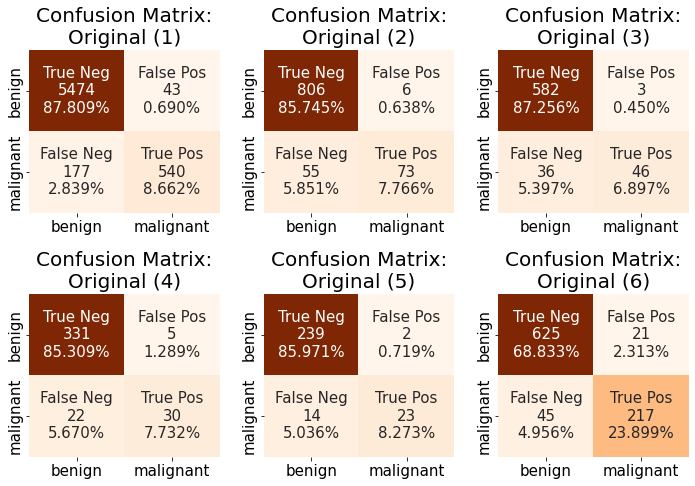

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.684  0.776 |  0.895   |     0.657     |    0.253    0.395 |
| FKT(2)  | 0.431  0.631 |  0.906   |     0.356     |    0.182    0.302 |
| FKT(3)  | 0.292  0.570 |  0.939   |     0.202     |    0.142    0.246 |
| FKT(4)  | 0.271  0.571 |  0.981   |     0.161     |    0.153    0.265 |
| FKT(5)  | 0.335  0.605 |  0.973   |     0.237     |    0.164    0.280 |
| FKT(6)  | 0.439  0.592 |  0.954   |     0.231     |    0.335    0.496 |
| Overall | 0.580  0.722 |  0.917   |     0.527     |    0.234    0.372 |
[array([[3624, 1893],
       [  75,  642]]), array([[289, 523],
       [ 12, 116]]), array([[118, 467],
       [  5,  77]]), array([[ 54, 282],
       [  1,  51]]), array([[ 57, 184],
       [  1,  36]]), array([[149, 497],
       [ 12, 250]])]


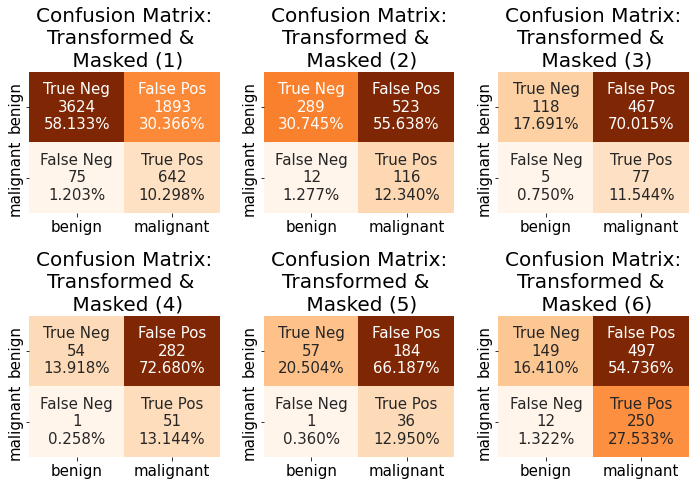

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.684  0.783 |  0.912   |     0.654     |    0.255    0.399 |
| FKT(2)  | 0.410  0.625 |  0.922   |     0.329     |    0.178    0.298 |
| FKT(3)  | 0.277  0.572 |  0.963   |     0.181     |    0.142    0.247 |
| FKT(4)  | 0.268  0.569 |  0.981   |     0.158     |    0.153    0.264 |
| FKT(5)  | 0.331  0.603 |  0.973   |     0.232     |    0.163    0.279 |
| FKT(6)  | 0.416  0.577 |  0.958   |     0.197     |    0.326    0.486 |
| Overall | 0.574  0.724 |  0.930   |     0.518     |    0.233    0.372 |
[array([[3609, 1908],
       [  63,  654]]), array([[267, 545],
       [ 10, 118]]), array([[106, 479],
       [  3,  79]]), array([[ 53, 283],
       [  1,  51]]), array([[ 56, 185],
       [  1,  36]]), array([[127, 519],
       [ 11, 251]])]


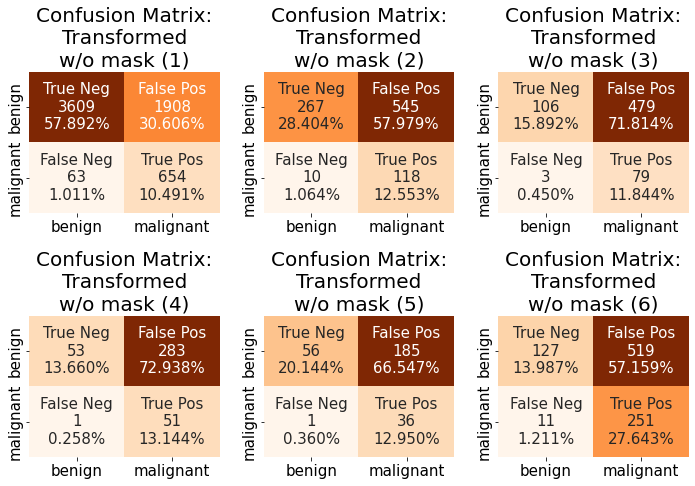

---Fairness metrics---
                        Disparate Impact  Statistical Parity  Equalized Odds  \
Original                        2.385906            0.073709        0.073709   
Transformed with masks          2.860000            0.429787        0.429787   
Transformed w/o masks           2.855094            0.427913        0.427913   

                        Predictive Rate Parity  Absolute Between-ROC Area  
Original                              0.020823                   0.021481  
Transformed with masks                0.034648                   0.155535  
Transformed w/o masks                 0.030141                   0.169008  
---ROC Curves---


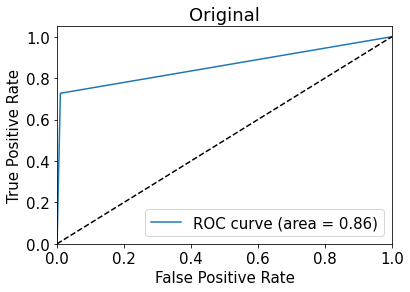

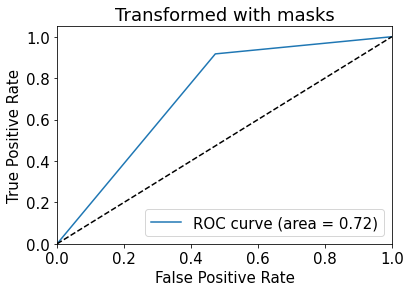

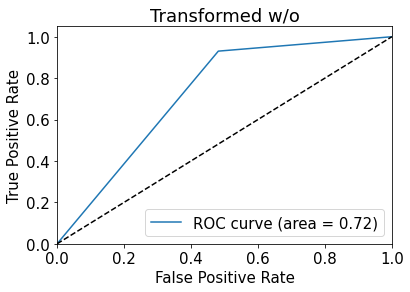

______________________________
### Running ResNet50_reg_used-Fold5_Epoch4_ValidAcc_0.944_ROC_0.910.pth####
Starting testing
1 - No image edits
2 - Transformed image using mask
3 - Transformed image without mask
| Runtime | fold | 1 Acc | 2 Acc | 3 Acc | 1 ROC | 2 ROC | 3 ROC | 1 recall | 2 recall | 3 recall | 1 specificity | 2 specificity | 3 specificity | 1 precision | 2 precision | 3 precision | 1 f1 | 2 f1 | 3 f1 |
| 0:00:26 |  0   | 0.899 | 0.892 | 0.890 | 0.856 | 0.943 | 0.928 |  0.469   |  0.410   |  0.392   |     0.990     |     0.994     |     0.995     |    0.908    |    0.933    |    0.939    |0.618 |0.570 |0.553 |
| 0:00:25 |  1   | 0.930 | 0.934 | 0.934 | 0.886 | 0.952 | 0.934 |  0.583   |  0.537   |  0.550   |     0.986     |     0.998     |     0.996     |    0.870    |    0.975    |    0.960    |0.698 |0.692 |0.700 |
| 0:00:26 |  2   | 0.935 | 0.941 | 0.939 | 0.880 | 0.947 | 0.938 |  0.632   |  0.526   |  0.521   |     0.977     |     0.998     |     0.997     |    0.789

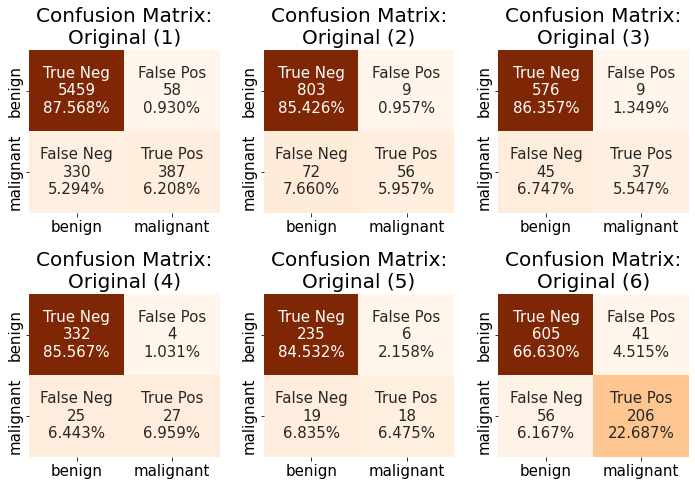

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.940  0.749 |  0.501   |     0.997     |    0.952    0.656 |
| FKT(2)  | 0.918  0.706 |  0.414   |     0.998     |    0.964    0.579 |
| FKT(3)  | 0.921  0.682 |  0.366   |     0.998     |    0.968    0.531 |
| FKT(4)  | 0.925  0.721 |  0.442   |     1.000     |    1.000    0.613 |
| FKT(5)  | 0.906  0.649 |  0.297   |     1.000     |    1.000    0.458 |
| FKT(6)  | 0.907  0.844 |  0.695   |     0.994     |    0.978    0.813 |
| Overall | 0.931  0.756 |  0.515   |     0.997     |    0.963    0.671 |
[array([[5499,   18],
       [ 358,  359]]), array([[810,   2],
       [ 75,  53]]), array([[584,   1],
       [ 52,  30]]), array([[336,   0],
       [ 29,  23]]), array([[241,   0],
       [ 26,  11]]), array([[642,   4],
       [ 80, 182]])]


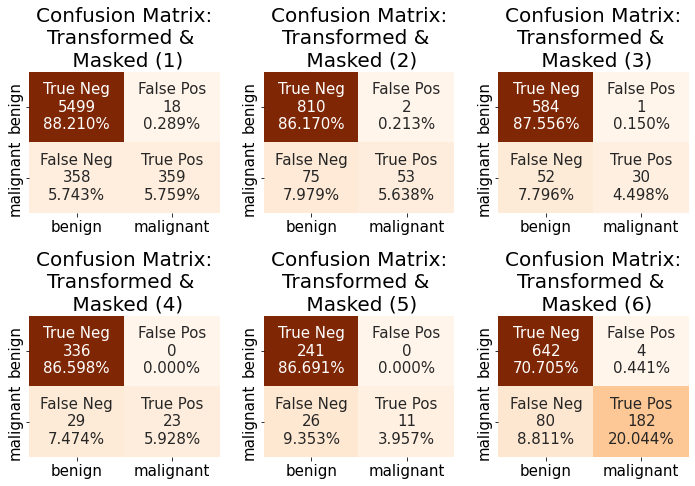

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.939  0.748 |  0.501   |     0.996     |    0.942    0.654 |
| FKT(2)  | 0.919  0.716 |  0.438   |     0.995     |    0.933    0.596 |
| FKT(3)  | 0.922  0.683 |  0.366   |     1.000     |    1.000    0.536 |
| FKT(4)  | 0.925  0.729 |  0.462   |     0.997     |    0.960    0.623 |
| FKT(5)  | 0.906  0.649 |  0.297   |     1.000     |    1.000    0.458 |
| FKT(6)  | 0.876  0.789 |  0.584   |     0.994     |    0.975    0.730 |
| Overall | 0.928  0.746 |  0.495   |     0.996     |    0.953    0.652 |
[array([[5495,   22],
       [ 358,  359]]), array([[808,   4],
       [ 72,  56]]), array([[585,   0],
       [ 52,  30]]), array([[335,   1],
       [ 28,  24]]), array([[241,   0],
       [ 26,  11]]), array([[642,   4],
       [109, 153]])]


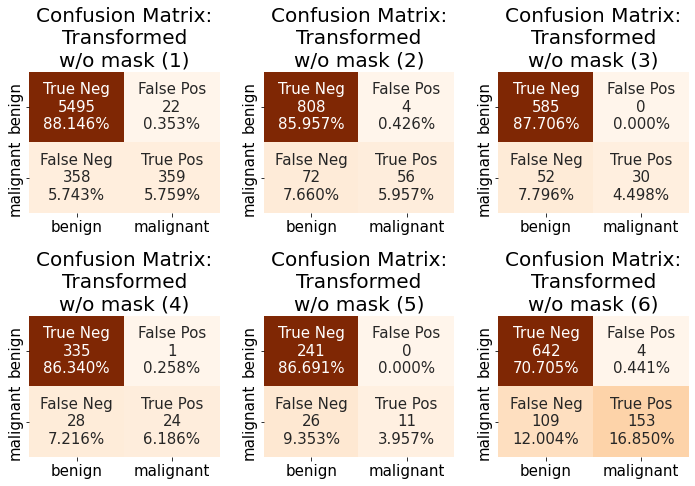

---Fairness metrics---
                        Disparate Impact  Statistical Parity  Equalized Odds  \
Original                        1.841060            0.228009        0.228009   
Transformed with masks          2.104545            0.138811        0.138811   
Transformed w/o masks           2.440415            0.055897        0.055897   

                        Predictive Rate Parity  Absolute Between-ROC Area  
Original                              0.032184                   0.083296  
Transformed with masks                0.027175                   0.069172  
Transformed w/o masks                 0.029295                   0.027621  
---ROC Curves---


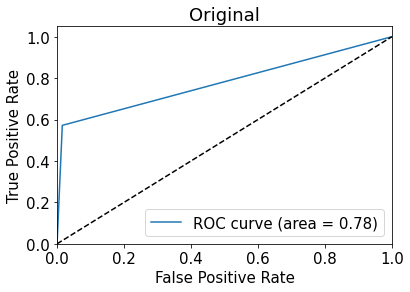

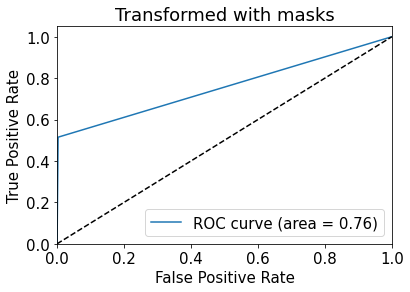

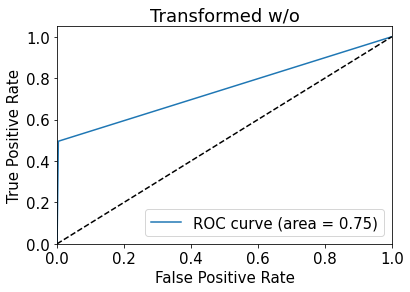

______________________________
### Running EfficientNet_B2_Fold3_Epoch14_ValidAcc_0.979_ROC_0.988.pth####
Loaded pretrained weights for efficientnet-b2
Starting testing
1 - No image edits
2 - Transformed image using mask
3 - Transformed image without mask
| Runtime | fold | 1 Acc | 2 Acc | 3 Acc | 1 ROC | 2 ROC | 3 ROC | 1 recall | 2 recall | 3 recall | 1 specificity | 2 specificity | 3 specificity | 1 precision | 2 precision | 3 precision | 1 f1 | 2 f1 | 3 f1 |
| 0:00:27 |  0   | 0.964 | 0.853 | 0.860 | 0.981 | 0.848 | 0.861 |  0.813   |  0.403   |  0.410   |     0.995     |     0.948     |     0.955     |    0.974    |    0.618    |    0.655    |0.886 |0.488 |0.505 |
| 0:00:29 |  1   | 0.972 | 0.890 | 0.897 | 0.980 | 0.876 | 0.865 |  0.812   |  0.546   |  0.550   |     0.998     |     0.945     |     0.953     |    0.983    |    0.617    |    0.652    |0.889 |0.579 |0.597 |
| 0:00:29 |  2   | 0.973 | 0.887 | 0.896 | 0.981 | 0.867 | 0.850 |  0.800   |  0.468   |  0.489   |     0.996  

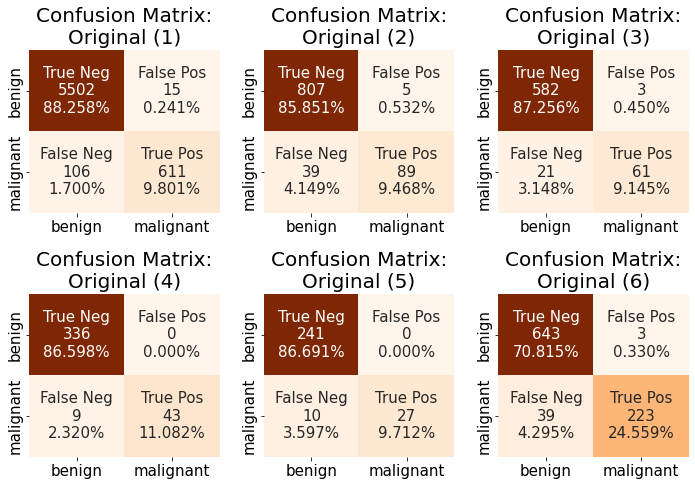

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.893  0.689 |  0.425   |     0.953     |    0.543    0.477 |
| FKT(2)  | 0.883  0.715 |  0.484   |     0.946     |    0.585    0.530 |
| FKT(3)  | 0.879  0.705 |  0.476   |     0.935     |    0.506    0.491 |
| FKT(4)  | 0.881  0.712 |  0.481   |     0.943     |    0.568    0.521 |
| FKT(5)  | 0.896  0.757 |  0.568   |     0.946     |    0.618    0.592 |
| FKT(6)  | 0.903  0.868 |  0.786   |     0.950     |    0.866    0.824 |
| Overall | 0.891  0.733 |  0.515   |     0.950     |    0.620    0.563 |
[array([[5260,  257],
       [ 412,  305]]), array([[768,  44],
       [ 66,  62]]), array([[547,  38],
       [ 43,  39]]), array([[317,  19],
       [ 27,  25]]), array([[228,  13],
       [ 16,  21]]), array([[614,  32],
       [ 56, 206]])]


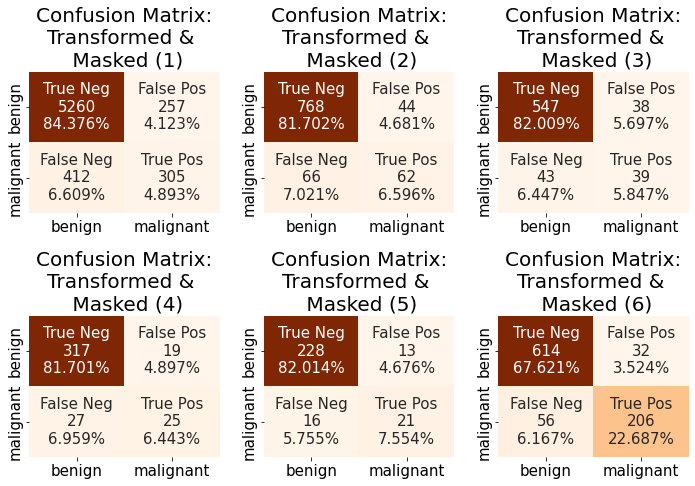

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.899  0.696 |  0.432   |     0.960     |    0.582    0.496 |
| FKT(2)  | 0.887  0.724 |  0.500   |     0.948     |    0.604    0.547 |
| FKT(3)  | 0.889  0.717 |  0.488   |     0.945     |    0.556    0.519 |
| FKT(4)  | 0.899  0.723 |  0.481   |     0.964     |    0.676    0.562 |
| FKT(5)  | 0.899  0.736 |  0.514   |     0.959     |    0.655    0.576 |
| FKT(6)  | 0.906  0.866 |  0.771   |     0.961     |    0.890    0.826 |
| Overall | 0.898  0.737 |  0.516   |     0.958     |    0.657    0.578 |
[array([[5294,  223],
       [ 407,  310]]), array([[770,  42],
       [ 64,  64]]), array([[553,  32],
       [ 42,  40]]), array([[324,  12],
       [ 27,  25]]), array([[231,  10],
       [ 18,  19]]), array([[621,  25],
       [ 60, 202]])]


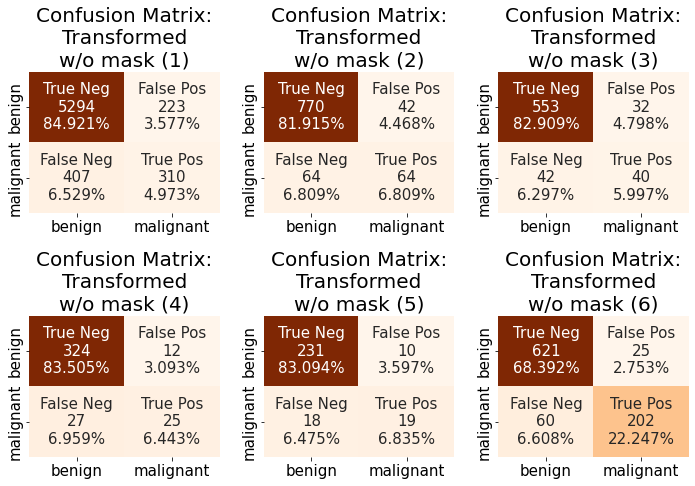

---Fairness metrics---
                        Disparate Impact  Statistical Parity  Equalized Odds  \
Original                        2.648649            0.014704        0.014704   
Transformed with masks          2.357595            0.283276        0.283276   
Transformed w/o masks           2.426621            0.258779        0.258779   

                        Predictive Rate Parity  Absolute Between-ROC Area  
Original                              0.019202                   0.007352  
Transformed with masks                0.252502                   0.138339  
Transformed w/o masks                 0.257312                   0.129389  
---ROC Curves---


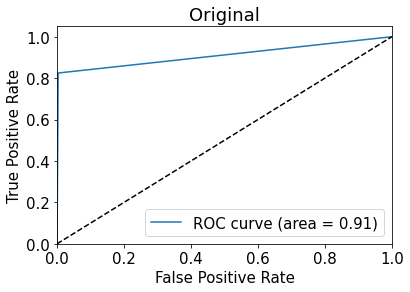

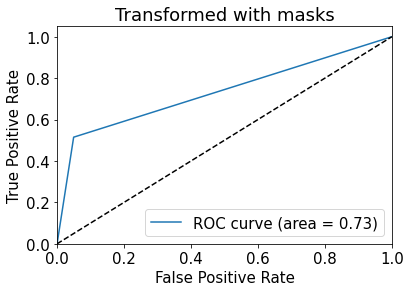

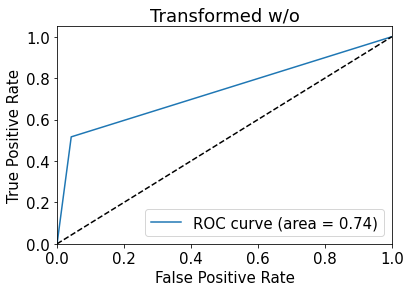

______________________________
### Running EfficientNet_B2_reg_used-Fold5_Epoch3_ValidAcc_0.945_ROC_0.919.pth####
Loaded pretrained weights for efficientnet-b2
Starting testing
1 - No image edits
2 - Transformed image using mask
3 - Transformed image without mask
| Runtime | fold | 1 Acc | 2 Acc | 3 Acc | 1 ROC | 2 ROC | 3 ROC | 1 recall | 2 recall | 3 recall | 1 specificity | 2 specificity | 3 specificity | 1 precision | 2 precision | 3 precision | 1 f1 | 2 f1 | 3 f1 |
| 0:00:27 |  0   | 0.903 | 0.927 | 0.908 | 0.884 | 0.967 | 0.955 |  0.505   |  0.597   |  0.487   |     0.987     |     0.996     |     0.997     |    0.890    |    0.970    |    0.971    |0.645 |0.739 |0.649 |
| 0:00:28 |  1   | 0.934 | 0.954 | 0.939 | 0.906 | 0.959 | 0.946 |  0.619   |  0.679   |  0.573   |     0.985     |     0.999     |     0.999     |    0.871    |    0.987    |    0.984    |0.724 |0.804 |0.725 |
| 0:00:28 |  2   | 0.939 | 0.961 | 0.945 | 0.914 | 0.968 | 0.955 |  0.611   |  0.695   |  0.574   |    

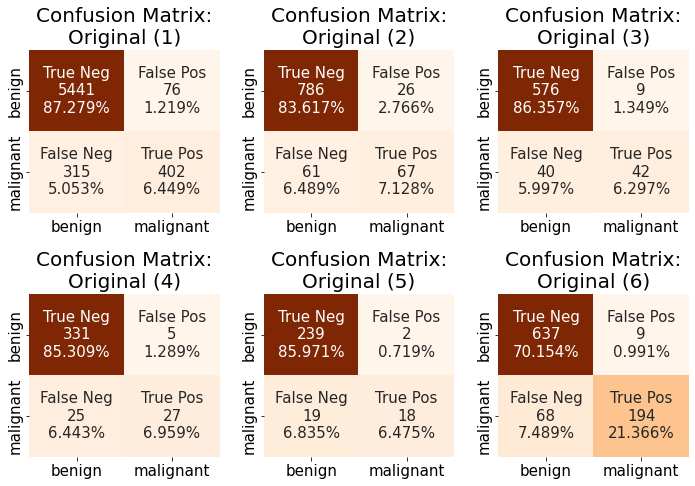

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.962  0.847 |  0.699   |     0.996     |    0.960    0.809 |
| FKT(2)  | 0.936  0.779 |  0.562   |     0.995     |    0.947    0.706 |
| FKT(3)  | 0.946  0.780 |  0.561   |     1.000     |    1.000    0.719 |
| FKT(4)  | 0.938  0.769 |  0.538   |     1.000     |    1.000    0.700 |
| FKT(5)  | 0.946  0.797 |  0.595   |     1.000     |    1.000    0.746 |
| FKT(6)  | 0.930  0.878 |  0.756   |     1.000     |    1.000    0.861 |
| Overall | 0.954  0.838 |  0.678   |     0.997     |    0.972    0.799 |
[array([[5496,   21],
       [ 216,  501]]), array([[808,   4],
       [ 56,  72]]), array([[585,   0],
       [ 36,  46]]), array([[336,   0],
       [ 24,  28]]), array([[241,   0],
       [ 15,  22]]), array([[646,   0],
       [ 64, 198]])]


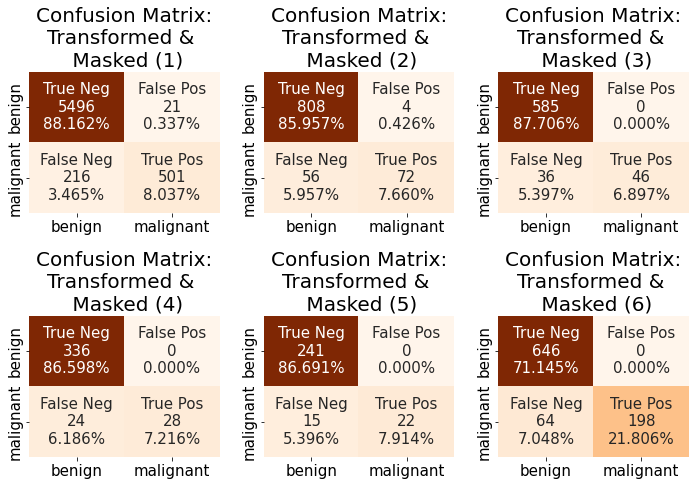

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.941  0.754 |  0.512   |     0.997     |    0.953    0.666 |
| FKT(2)  | 0.931  0.759 |  0.523   |     0.995     |    0.944    0.673 |
| FKT(3)  | 0.940  0.756 |  0.512   |     1.000     |    1.000    0.677 |
| FKT(4)  | 0.938  0.769 |  0.538   |     1.000     |    1.000    0.700 |
| FKT(5)  | 0.942  0.784 |  0.568   |     1.000     |    1.000    0.724 |
| FKT(6)  | 0.913  0.849 |  0.698   |     1.000     |    1.000    0.822 |
| Overall | 0.937  0.776 |  0.554   |     0.997     |    0.970    0.705 |
[array([[5499,   18],
       [ 350,  367]]), array([[808,   4],
       [ 61,  67]]), array([[585,   0],
       [ 40,  42]]), array([[336,   0],
       [ 24,  28]]), array([[241,   0],
       [ 16,  21]]), array([[646,   0],
       [ 79, 183]])]


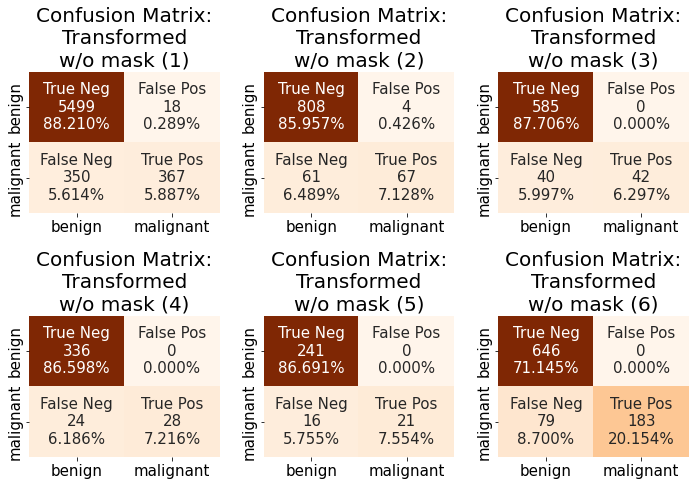

---Fairness metrics---
                        Disparate Impact  Statistical Parity  Equalized Odds  \
Original                        2.439216            0.132643        0.132643   
Transformed with masks          2.596774            0.042423        0.042423   
Transformed w/o masks           2.146552            0.150666        0.150666   

                        Predictive Rate Parity  Absolute Between-ROC Area  
Original                              0.115711                   0.066321  
Transformed with masks                0.038820                   0.021212  
Transformed w/o masks                 0.044177                   0.075333  
---ROC Curves---


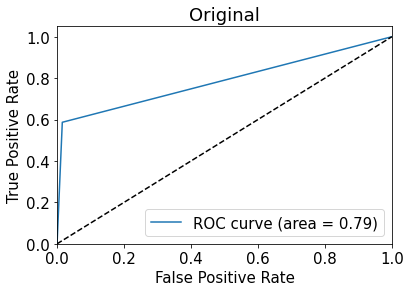

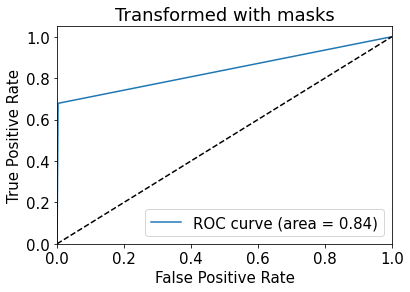

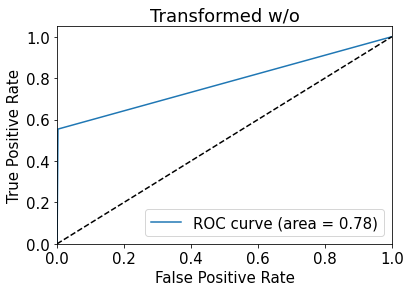

______________________________
### Running EfficientNet_B4-Fold4_Epoch9_ValidAcc_0.975_ROC_0.980.pth####
Loaded pretrained weights for efficientnet-b4
Starting testing
1 - No image edits
2 - Transformed image using mask
3 - Transformed image without mask
| Runtime | fold | 1 Acc | 2 Acc | 3 Acc | 1 ROC | 2 ROC | 3 ROC | 1 recall | 2 recall | 3 recall | 1 specificity | 2 specificity | 3 specificity | 1 precision | 2 precision | 3 precision | 1 f1 | 2 f1 | 3 f1 |
| 0:00:31 |  0   | 0.950 | 0.874 | 0.868 | 0.974 | 0.793 | 0.817 |  0.733   |  0.322   |  0.282   |     0.996     |     0.990     |     0.992     |    0.976    |    0.871    |    0.875    |0.837 |0.471 |0.427 |
| 0:00:32 |  1   | 0.967 | 0.917 | 0.916 | 0.967 | 0.864 | 0.867 |  0.771   |  0.422   |  0.404   |     0.999     |     0.997     |     0.999     |    0.988    |    0.958    |    0.978    |0.866 |0.586 |0.571 |
| 0:00:32 |  2   | 0.968 | 0.925 | 0.924 | 0.968 | 0.854 | 0.858 |  0.753   |  0.395   |  0.379   |     0.998   

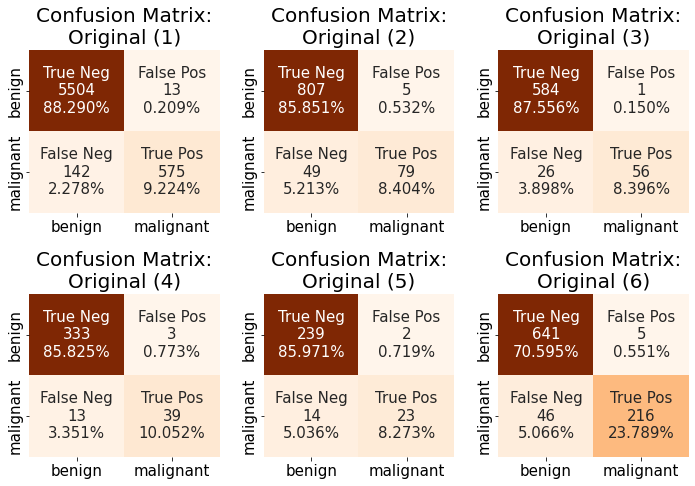

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.917  0.659 |  0.324   |     0.994     |    0.879    0.473 |
| FKT(2)  | 0.913  0.683 |  0.367   |     0.999     |    0.979    0.534 |
| FKT(3)  | 0.913  0.652 |  0.305   |     0.998     |    0.962    0.463 |
| FKT(4)  | 0.910  0.663 |  0.327   |     1.000     |    1.000    0.493 |
| FKT(5)  | 0.896  0.608 |  0.216   |     1.000     |    1.000    0.356 |
| FKT(6)  | 0.916  0.855 |  0.710   |     1.000     |    1.000    0.830 |
| Overall | 0.915  0.699 |  0.403   |     0.996     |    0.938    0.564 |
[array([[5485,   32],
       [ 485,  232]]), array([[811,   1],
       [ 81,  47]]), array([[584,   1],
       [ 57,  25]]), array([[336,   0],
       [ 35,  17]]), array([[241,   0],
       [ 29,   8]]), array([[646,   0],
       [ 76, 186]])]


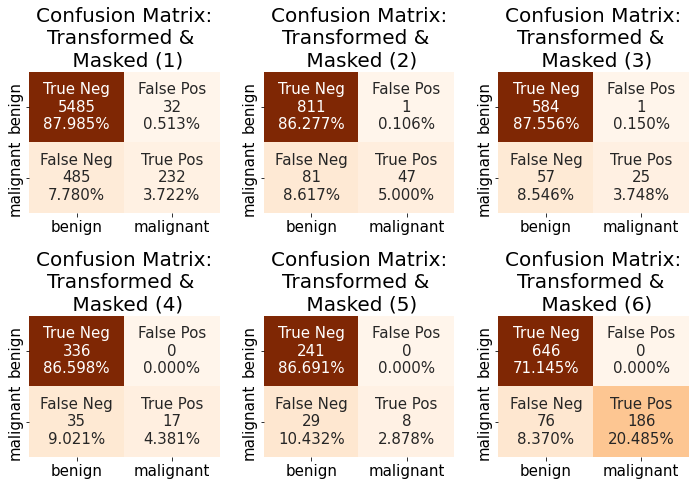

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.915  0.644 |  0.293   |     0.995     |    0.890    0.441 |
| FKT(2)  | 0.911  0.675 |  0.352   |     0.999     |    0.978    0.517 |
| FKT(3)  | 0.912  0.645 |  0.293   |     0.998     |    0.960    0.449 |
| FKT(4)  | 0.912  0.673 |  0.346   |     1.000     |    1.000    0.514 |
| FKT(5)  | 0.896  0.608 |  0.216   |     1.000     |    1.000    0.356 |
| FKT(6)  | 0.909  0.842 |  0.683   |     1.000     |    1.000    0.812 |
| Overall | 0.913  0.688 |  0.379   |     0.997     |    0.945    0.541 |
[array([[5491,   26],
       [ 507,  210]]), array([[811,   1],
       [ 83,  45]]), array([[584,   1],
       [ 58,  24]]), array([[336,   0],
       [ 34,  18]]), array([[241,   0],
       [ 29,   8]]), array([[646,   0],
       [ 83, 179]])]


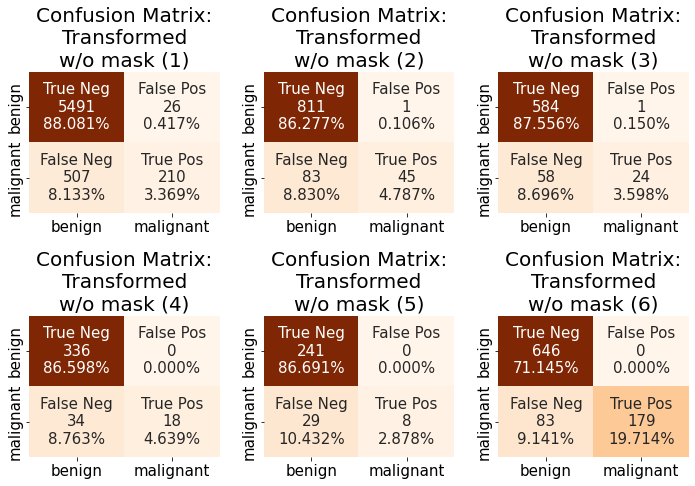

---Fairness metrics---
                        Disparate Impact  Statistical Parity  Equalized Odds  \
Original                        2.531250            0.031540        0.031540   
Transformed with masks          1.601896            0.278118        0.278118   
Transformed w/o masks           1.497561            0.287124        0.287124   

                        Predictive Rate Parity  Absolute Between-ROC Area  
Original                              0.008659                   0.010341  
Transformed with masks                0.100592                   0.139059  
Transformed w/o masks                 0.091205                   0.143562  
---ROC Curves---


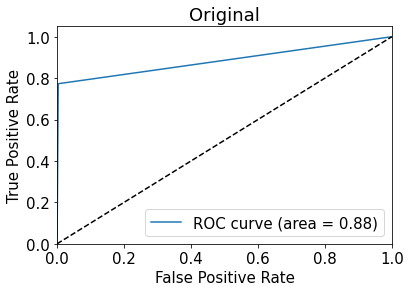

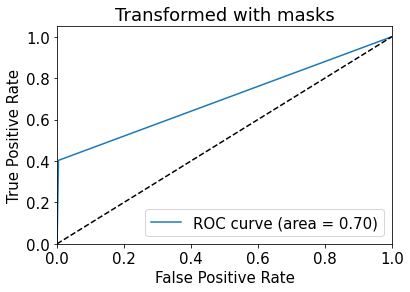

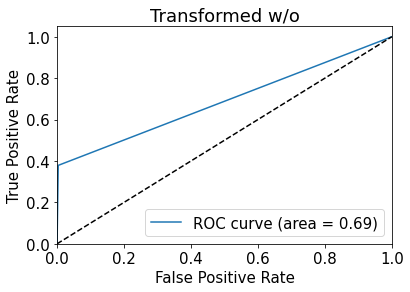

______________________________
### Running EfficientNet_B4_reg_used-Fold5_Epoch2_ValidAcc_0.948_ROC_0.940.pth####
Loaded pretrained weights for efficientnet-b4
Starting testing
1 - No image edits
2 - Transformed image using mask
3 - Transformed image without mask
| Runtime | fold | 1 Acc | 2 Acc | 3 Acc | 1 ROC | 2 ROC | 3 ROC | 1 recall | 2 recall | 3 recall | 1 specificity | 2 specificity | 3 specificity | 1 precision | 2 precision | 3 precision | 1 f1 | 2 f1 | 3 f1 |
| 0:00:32 |  0   | 0.898 | 0.937 | 0.915 | 0.908 | 0.969 | 0.948 |  0.458   |  0.689   |  0.575   |     0.991     |     0.989     |     0.986     |    0.912    |    0.931    |    0.897    |0.610 |0.792 |0.701 |
| 0:00:33 |  1   | 0.934 | 0.957 | 0.951 | 0.924 | 0.964 | 0.950 |  0.564   |  0.761   |  0.702   |     0.993     |     0.989     |     0.991     |    0.932    |    0.917    |    0.927    |0.703 |0.832 |0.799 |
| 0:00:31 |  2   | 0.939 | 0.959 | 0.949 | 0.928 | 0.970 | 0.951 |  0.563   |  0.742   |  0.647   |    

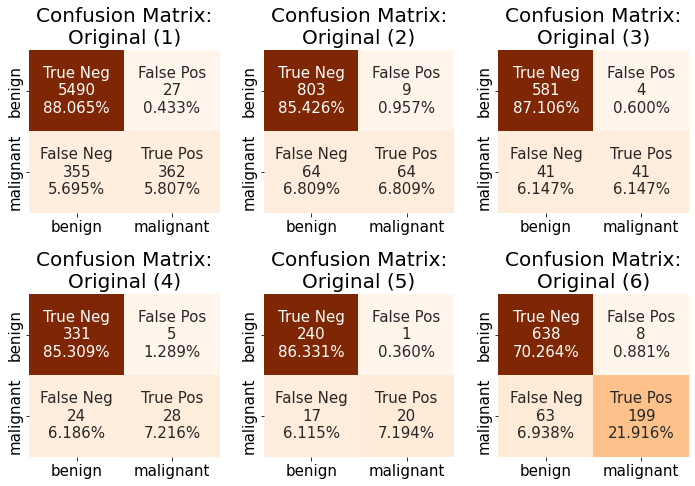

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.966  0.892 |  0.795   |     0.989     |    0.902    0.845 |
| FKT(2)  | 0.933  0.800 |  0.617   |     0.983     |    0.849    0.715 |
| FKT(3)  | 0.945  0.790 |  0.585   |     0.995     |    0.941    0.722 |
| FKT(4)  | 0.941  0.787 |  0.577   |     0.997     |    0.968    0.723 |
| FKT(5)  | 0.953  0.824 |  0.649   |     1.000     |    1.000    0.787 |
| FKT(6)  | 0.938  0.898 |  0.802   |     0.994     |    0.981    0.882 |
| Overall | 0.957  0.871 |  0.752   |     0.990     |    0.920    0.827 |
[array([[5455,   62],
       [ 147,  570]]), array([[798,  14],
       [ 49,  79]]), array([[582,   3],
       [ 34,  48]]), array([[335,   1],
       [ 22,  30]]), array([[241,   0],
       [ 13,  24]]), array([[642,   4],
       [ 52, 210]])]


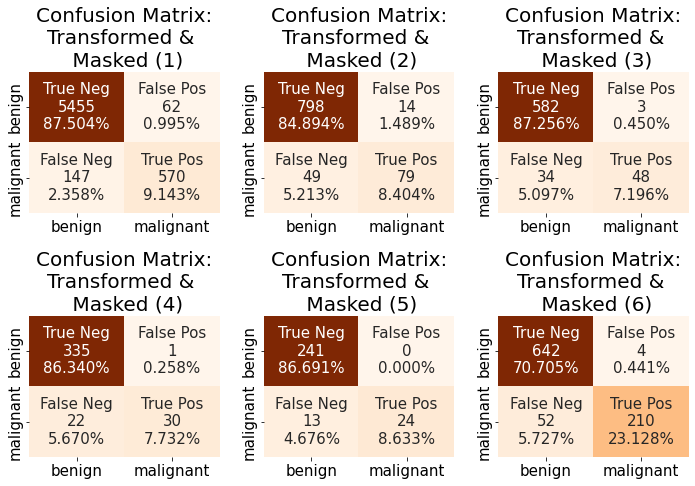

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.953  0.826 |  0.661   |     0.991     |    0.903    0.763 |
| FKT(2)  | 0.926  0.779 |  0.578   |     0.980     |    0.822    0.679 |
| FKT(3)  | 0.943  0.784 |  0.573   |     0.995     |    0.940    0.712 |
| FKT(4)  | 0.946  0.798 |  0.596   |     1.000     |    1.000    0.747 |
| FKT(5)  | 0.950  0.811 |  0.622   |     1.000     |    1.000    0.767 |
| FKT(6)  | 0.930  0.880 |  0.763   |     0.997     |    0.990    0.862 |
| Overall | 0.947  0.828 |  0.664   |     0.991     |    0.922    0.772 |
[array([[5466,   51],
       [ 243,  474]]), array([[796,  16],
       [ 54,  74]]), array([[582,   3],
       [ 35,  47]]), array([[336,   0],
       [ 21,  31]]), array([[241,   0],
       [ 14,  23]]), array([[644,   2],
       [ 62, 200]])]


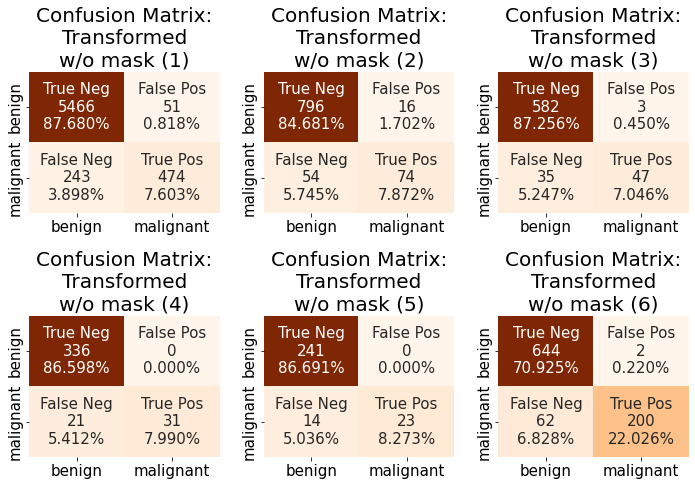

---Fairness metrics---
                        Disparate Impact  Statistical Parity  Equalized Odds  \
Original                        1.942529            0.205590        0.205590   
Transformed with masks          2.884758            0.007587        0.007587   
Transformed w/o masks           2.597656            0.090280        0.090280   

                        Predictive Rate Parity  Absolute Between-ROC Area  
Original                              0.025256                   0.097133  
Transformed with masks                0.083217                   0.003793  
Transformed w/o masks                 0.097451                   0.045140  
---ROC Curves---


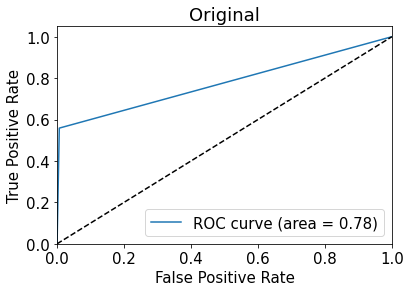

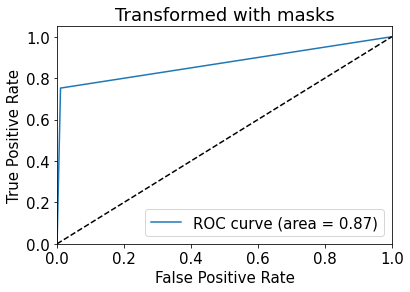

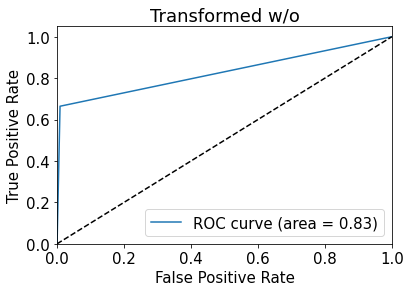

______________________________
### Running EfficientNet_B7-Fold3_Epoch1_ValidAcc_0.969_ROC_0.980.pth####


Downloading: "https://github.com/lukemelas/EfficientNet-PyTorch/releases/download/1.0/efficientnet-b7-dcc49843.pth" to /root/.cache/torch/hub/checkpoints/efficientnet-b7-dcc49843.pth


  0%|          | 0.00/254M [00:00<?, ?B/s]

Loaded pretrained weights for efficientnet-b7
Starting testing
1 - No image edits
2 - Transformed image using mask
3 - Transformed image without mask
| Runtime | fold | 1 Acc | 2 Acc | 3 Acc | 1 ROC | 2 ROC | 3 ROC | 1 recall | 2 recall | 3 recall | 1 specificity | 2 specificity | 3 specificity | 1 precision | 2 precision | 3 precision | 1 f1 | 2 f1 | 3 f1 |
| 0:01:01 |  0   | 0.934 | 0.876 | 0.876 | 0.971 | 0.865 | 0.879 |  0.692   |  0.462   |  0.396   |     0.985     |     0.963     |     0.978     |    0.909    |    0.724    |    0.788    |0.786 |0.564 |0.527 |
| 0:01:00 |  1   | 0.960 | 0.905 | 0.921 | 0.966 | 0.880 | 0.890 |  0.761   |  0.537   |  0.532   |     0.993     |     0.964     |     0.984     |    0.943    |    0.709    |    0.841    |0.843 |0.611 |0.652 |
| 0:01:00 |  2   | 0.969 | 0.925 | 0.932 | 0.972 | 0.897 | 0.898 |  0.774   |  0.547   |  0.516   |     0.996     |     0.978     |     0.989     |    0.961    |    0.770    |    0.867    |0.857 |0.640 |0.647 |
| 0:01

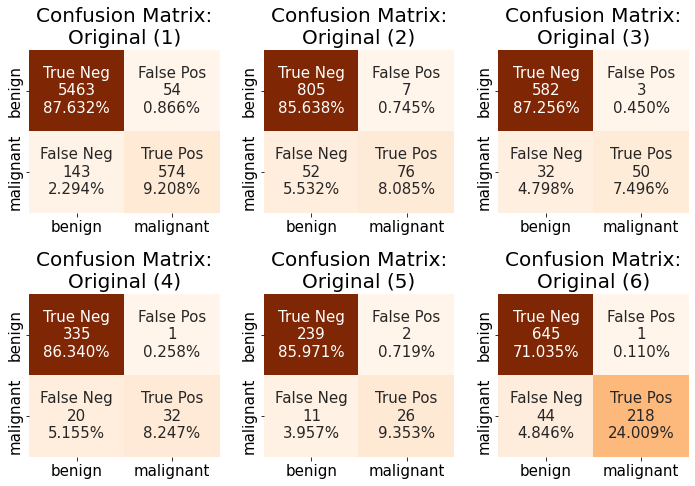

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.913  0.728 |  0.488   |     0.968     |    0.665    0.563 |
| FKT(2)  | 0.923  0.755 |  0.523   |     0.986     |    0.859    0.650 |
| FKT(3)  | 0.916  0.716 |  0.451   |     0.981     |    0.771    0.569 |
| FKT(4)  | 0.930  0.781 |  0.577   |     0.985     |    0.857    0.690 |
| FKT(5)  | 0.946  0.809 |  0.622   |     0.996     |    0.958    0.754 |
| FKT(6)  | 0.907  0.868 |  0.775   |     0.961     |    0.890    0.829 |
| Overall | 0.915  0.764 |  0.556   |     0.972     |    0.756    0.641 |
[array([[5341,  176],
       [ 367,  350]]), array([[801,  11],
       [ 61,  67]]), array([[574,  11],
       [ 45,  37]]), array([[331,   5],
       [ 22,  30]]), array([[240,   1],
       [ 14,  23]]), array([[621,  25],
       [ 59, 203]])]


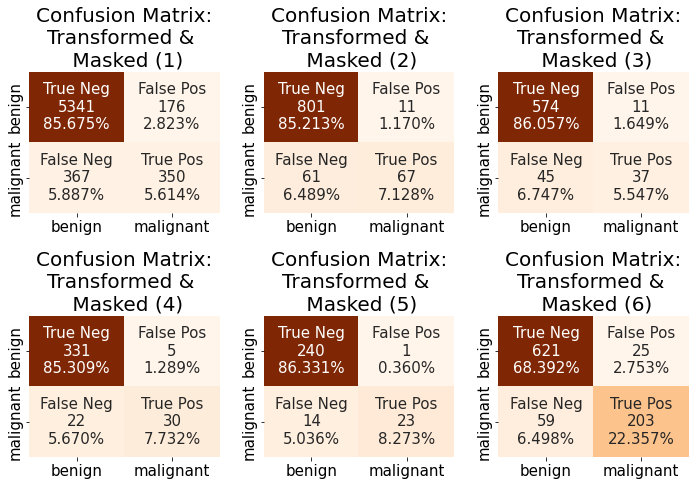

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.921  0.695 |  0.402   |     0.989     |    0.823    0.540 |
| FKT(2)  | 0.923  0.748 |  0.508   |     0.989     |    0.878    0.644 |
| FKT(3)  | 0.924  0.731 |  0.476   |     0.986     |    0.830    0.605 |
| FKT(4)  | 0.933  0.791 |  0.596   |     0.985     |    0.861    0.705 |
| FKT(5)  | 0.950  0.834 |  0.676   |     0.992     |    0.926    0.781 |
| FKT(6)  | 0.898  0.872 |  0.813   |     0.932     |    0.829    0.821 |
| Overall | 0.921  0.751 |  0.517   |     0.984     |    0.836    0.639 |
[array([[5455,   62],
       [ 429,  288]]), array([[803,   9],
       [ 63,  65]]), array([[577,   8],
       [ 43,  39]]), array([[331,   5],
       [ 21,  31]]), array([[239,   2],
       [ 12,  25]]), array([[602,  44],
       [ 49, 213]])]


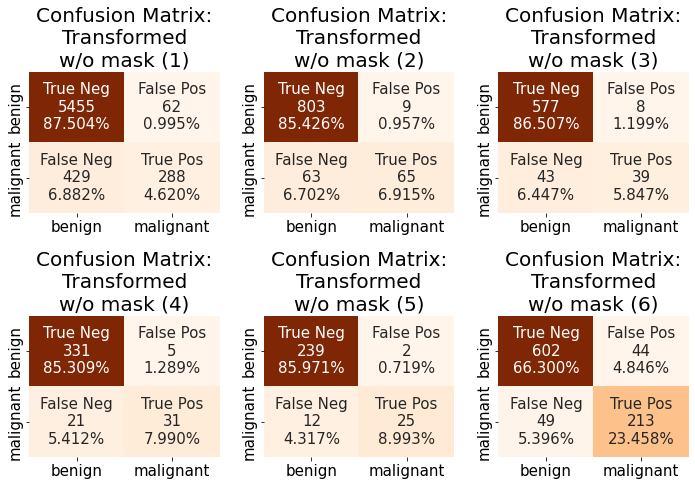

---Fairness metrics---
                        Disparate Impact  Statistical Parity  Equalized Odds  \
Original                        2.728571            0.037187        0.037187   
Transformed with masks          2.271777            0.242883        0.242883   
Transformed w/o masks           1.471875            0.373787        0.373787   

                        Predictive Rate Parity  Absolute Between-ROC Area  
Original                              0.069484                   0.018593  
Transformed with masks                0.195667                   0.121441  
Transformed w/o masks                 0.008353                   0.156619  
---ROC Curves---


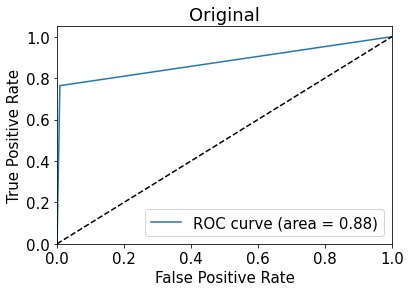

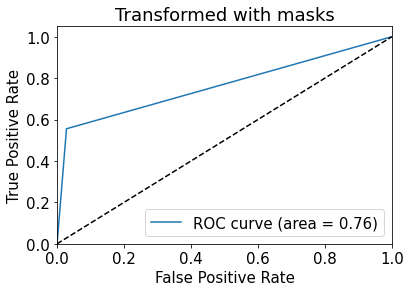

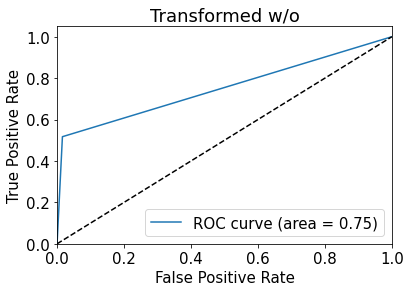

______________________________
### Running EfficientNet_B7_reg_used-Fold4_Epoch5_ValidAcc_0.941_ROC_0.916.pth####
Loaded pretrained weights for efficientnet-b7
Starting testing
1 - No image edits
2 - Transformed image using mask
3 - Transformed image without mask
| Runtime | fold | 1 Acc | 2 Acc | 3 Acc | 1 ROC | 2 ROC | 3 ROC | 1 recall | 2 recall | 3 recall | 1 specificity | 2 specificity | 3 specificity | 1 precision | 2 precision | 3 precision | 1 f1 | 2 f1 | 3 f1 |
| 0:01:00 |  0   | 0.896 | 0.913 | 0.890 | 0.915 | 0.931 | 0.891 |  0.484   |  0.560   |  0.462   |     0.983     |     0.987     |     0.980     |    0.857    |    0.900    |    0.829    |0.618 |0.691 |0.593 |
| 0:01:00 |  1   | 0.934 | 0.939 | 0.917 | 0.924 | 0.932 | 0.882 |  0.578   |  0.610   |  0.518   |     0.992     |     0.992     |     0.981     |    0.920    |    0.924    |    0.813    |0.710 |0.735 |0.633 |
| 0:01:01 |  2   | 0.933 | 0.947 | 0.927 | 0.915 | 0.959 | 0.890 |  0.547   |  0.626   |  0.526   |    

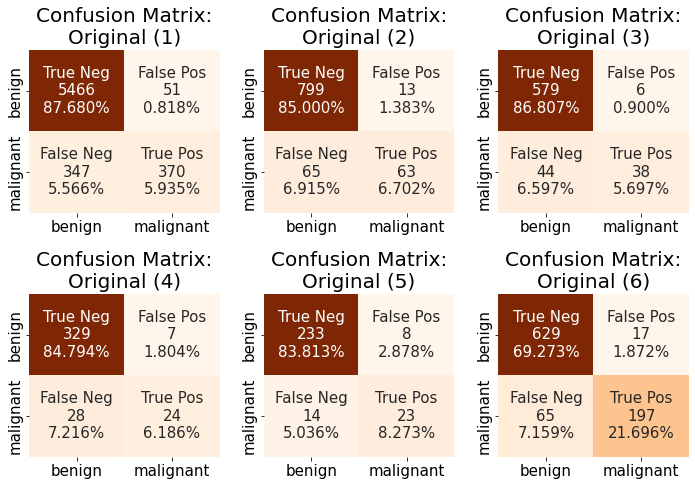

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.954  0.824 |  0.654   |     0.993     |    0.925    0.766 |
| FKT(2)  | 0.929  0.758 |  0.523   |     0.993     |    0.918    0.667 |
| FKT(3)  | 0.940  0.761 |  0.524   |     0.998     |    0.977    0.683 |
| FKT(4)  | 0.923  0.760 |  0.538   |     0.982     |    0.824    0.651 |
| FKT(5)  | 0.932  0.789 |  0.595   |     0.983     |    0.846    0.698 |
| FKT(6)  | 0.869  0.797 |  0.626   |     0.967     |    0.886    0.734 |
| Overall | 0.940  0.806 |  0.621   |     0.991     |    0.913    0.739 |
[array([[5479,   38],
       [ 248,  469]]), array([[806,   6],
       [ 61,  67]]), array([[584,   1],
       [ 39,  43]]), array([[330,   6],
       [ 24,  28]]), array([[237,   4],
       [ 15,  22]]), array([[625,  21],
       [ 98, 164]])]


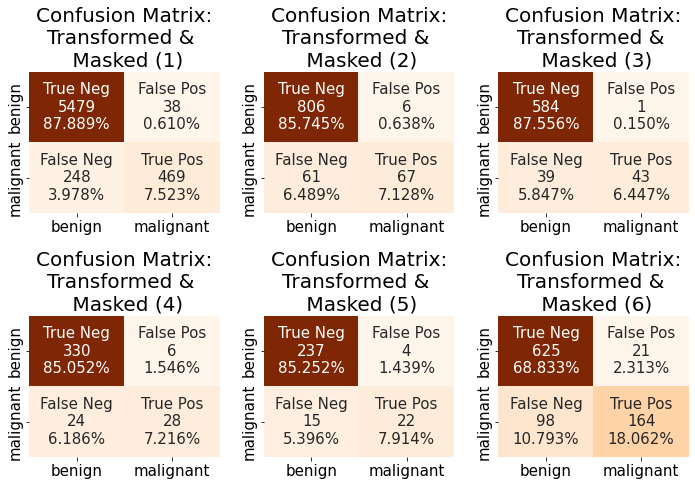

|   FKT   |Accuracy  ROC  |Sensitivity|  specificity  |  precision    f1  |
| FKT(1)  | 0.935  0.762 |  0.538   |     0.987     |    0.839    0.656 |
| FKT(2)  | 0.922  0.758 |  0.531   |     0.984     |    0.840    0.651 |
| FKT(3)  | 0.930  0.745 |  0.500   |     0.990     |    0.872    0.636 |
| FKT(4)  | 0.930  0.765 |  0.538   |     0.991     |    0.903    0.675 |
| FKT(5)  | 0.924  0.796 |  0.622   |     0.971     |    0.767    0.687 |
| FKT(6)  | 0.815  0.718 |  0.489   |     0.947     |    0.790    0.604 |
| Overall | 0.921  0.755 |  0.527   |     0.983     |    0.831    0.645 |
[array([[5443,   74],
       [ 331,  386]]), array([[799,  13],
       [ 60,  68]]), array([[579,   6],
       [ 41,  41]]), array([[333,   3],
       [ 24,  28]]), array([[234,   7],
       [ 14,  23]]), array([[612,  34],
       [134, 128]])]


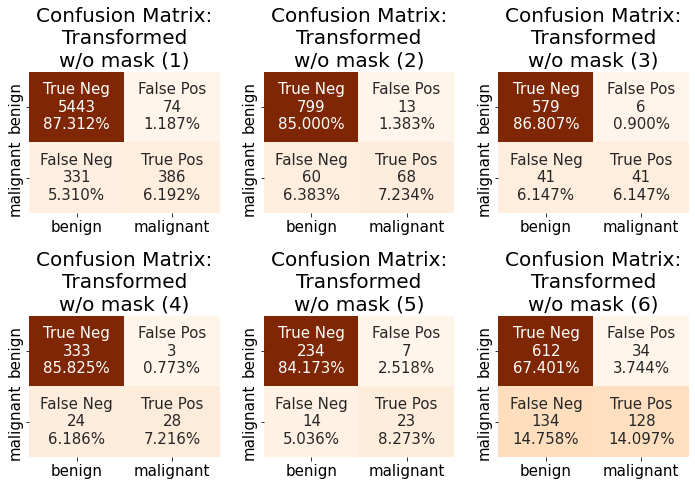

---Fairness metrics---
                        Disparate Impact  Statistical Parity  Equalized Odds  \
Original                        1.960145            0.203107        0.203107   
Transformed with masks          2.546939            0.033748        0.033748   
Transformed w/o masks           2.636771            0.046535        0.046535   

                        Predictive Rate Parity  Absolute Between-ROC Area  
Original                              0.013448                   0.085513  
Transformed with masks                0.054415                   0.016874  
Transformed w/o masks                 0.039146                   0.023268  
---ROC Curves---


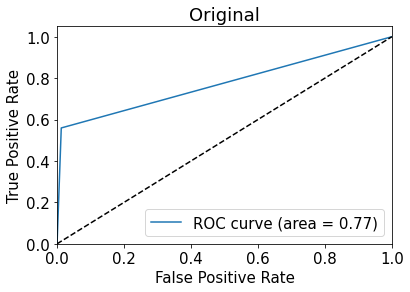

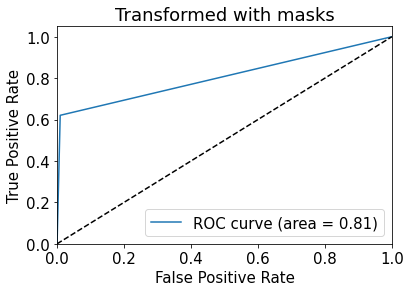

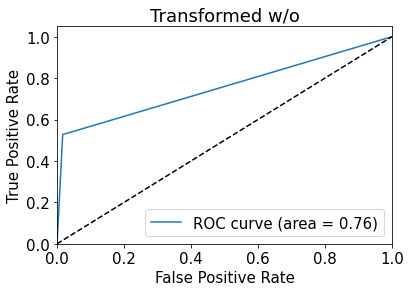

______________________________


In [132]:
for model_fn in models:
    print(f"### Running {model_fn}####")
    # set up model

    model_fn = str(model_fn)

    if "EfficientNet" in model_fn:
        if "B2" in model_fn:
            b2 = True
            b4 = False
        elif "B4" in model_fn:
            b2 = False
            b4 = True
        else:
            b2 = False
            b4 = False
        best_model = EfficientNetworkImageOnly(output_size = output_size, b4=b4, b2=b2).to(device)
        
    else:
        best_model = ResNet50NetworkImageOnly(output_size=output_size).to(device)


    best_model.load_state_dict(torch.load(model_fn, map_location=torch.device(device)))
    mask_path = Path("../input/melanoma_masks/results1")
    group_key = "ID"
    k = 6
    oof, oof_transformed, oof_transformed_without_mask  = test_folds(best_model, valid_df, mask_path, group_key, k, "v00")
    
    print("---Confusion metrics---")
    oof_df = pd.DataFrame(data = oof, columns=['oof'])
    oof_transformed_df = pd.DataFrame(data = oof_transformed, columns=['oof'])
    oof_transformed_without_mask_df = pd.DataFrame(data = oof_transformed_without_mask, columns=['oof'])
    create_confusion_matrix_agg(oof_df, valid_df, "Confusion Matrix:\nOriginal")
    create_confusion_matrix_agg(oof_transformed_df, valid_df, "Confusion Matrix:\nTransformed & \n Masked")
    create_confusion_matrix_agg(oof_transformed_without_mask_df, valid_df, "Confusion Matrix:\nTransformed\nw/o mask")
    
    print("---Fairness metrics---")
    disp_imp_1, stat_par_1, eq_odds_1, pred_rate_par_1, abra_1 = compute_fairness_metrics(oof_df, valid_df)
    disp_imp_2, stat_par_2, eq_odds_2, pred_rate_par_2, abra_2 = compute_fairness_metrics(oof_transformed_df, valid_df)
    disp_imp_3, stat_par_3, eq_odds_3, pred_rate_par_3, abra_3 = compute_fairness_metrics(oof_transformed_without_mask_df, valid_df)


    results = {
        "Original": {"Disparate Impact": disp_imp_1, 
                "Statistical Parity": stat_par_1, 
                "Equalized Odds": eq_odds_1, 
                "Predictive Rate Parity": pred_rate_par_1,
                "Absolute Between-ROC Area": abra_1},
        "Transformed with masks": {"Disparate Impact": disp_imp_2, 
                "Statistical Parity": stat_par_2, 
                "Equalized Odds": eq_odds_2, 
                "Predictive Rate Parity": pred_rate_par_2,
                "Absolute Between-ROC Area": abra_2},
        "Transformed w/o masks": {"Disparate Impact": disp_imp_3, 
                "Statistical Parity": stat_par_3, 
                "Equalized Odds": eq_odds_3, 
                "Predictive Rate Parity": pred_rate_par_3,
                "Absolute Between-ROC Area": abra_3}
    }

    df = pd.DataFrame.from_dict(results, orient='index')
    print(df.head())

    print("---ROC Curves---")
    labels = valid_df['target']
    y_pred = oof_df['oof'].astype(int)
    display_roc(labels, y_pred, "Original")

    y_pred = oof_transformed_df['oof'].astype(int)
    display_roc(labels, y_pred, "Transformed with masks")

    y_pred = oof_transformed_without_mask_df['oof'].astype(int)
    display_roc(labels, y_pred, "Transformed w/o")

    print("______________________________")

# XAI
This section will go over how to implement Captum's libary with different XAI tecniques 

In [ ]:
mask_path = Path("/input/melanoma_masks/results1")
example_data = MelanomaDataset(valid_df, vertical_flip=0.5, horizontal_flip=0.5, 
                               is_train=True, is_valid=False, is_test=False, generate_skin_transform=True, mask_path=mask_path)
example_loader = torch.utils.data.DataLoader(example_data, batch_size = 3, shuffle=True)


def get_an_example():    
    # Get a sample
    for (images, csv_data, image_path, ita_value, fst, transformed_image, transformed_image_wihtout_mask), labels in example_loader:
        mask_path = Path("/input/melanoma_masks/results1")
        image_example, csv_data_example = images, csv_data
        
        image_rgb = cv2.imread(image_path[0])
        image_rgb = cv2.resize(image_rgb, (224, 224), interpolation = cv2.INTER_LINEAR)
        file_name = Path(image_path[0]).name
        print(file_name)

        updated_mask_path = mask_path / str(file_name).replace("jpg", "png")
        print(updated_mask_path)

        
        im = Image.open(str(updated_mask_path))
        
        #mask_rgb = cv2.imread(str(updated_mask_path))
        #mask_rgb = cv2.resize(mask_rgb, (224, 224), interpolation = cv2.INTER_LINEAR)
        mask = im.resize((224, 224))
        
        mask = mask.rotate(270)
        #im = im.transpose(Image.FLIP_TOP_BOTTOM)
        #mask = mask.rotate(180)
        mask = mask.transpose(Image.FLIP_LEFT_RIGHT)        

        
        #csv_data_example = csv_data_example.to(device)
        image_example = torch.tensor(image_example, device=device, dtype=torch.float32)
        labels_example = torch.tensor(labels, device=device, dtype=torch.int64)
        return image_example, image_path, image_rgb, labels_example, ita_value, fst, mask, transformed_image, transformed_image_wihtout_mask


In [ ]:
file_count = len(list(mask_path.glob("*.png")))
file_count

## GuidedGradCam

In [ ]:
print(labels_example)
print(labels_example.dtype)
print(labels_example.shape)

In [ ]:
summary(best_model, (3,224,224))

In [ ]:
#pytorch_grad_cam
target_layers = []

In [ ]:
#gradcam = GuidedGradCam(best_model.features, layer=best_model.features._fc) 

In [ ]:
#out = best_model(image_example)
#print(out)
#out = torch.sigmoid(out)
#print(out)

In [ ]:
labels_example[0].cpu().numpy()

In [ ]:
# Generate heatmap
#heatmap = gradcam.attribute(image_example, labels_example)
#print(heatmap)
# Normalize heatmap
#heatmap = heatmap - heatmap.min()
#heatmap = heatmap / heatmap.max()

# Plot heatmap
#import matplotlib.pyplot as plt
#plt.imshow(heatmap.squeeze(), cmap='jet')
#plt.show()

In [ ]:
model = resnet50(pretrained=True)
target_layers = [model.layer4[-1]]
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)

In [ ]:
image_example.shape

## pytorch_grad_cam

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
target_layers = [best_model.features._conv_head, best_model.features._bn1, best_model.features._bn0]
cam = GradCAM(model=best_model, target_layers=target_layers, use_cuda=True)

In [ ]:
#TODO- Fix get example to pass in params of things that we want
image_example, image_path, image_rgb, labels_example, ita_value, fst, mask, transformed_image, transformed_image_wihtout_mask = get_an_example()


In [ ]:
plt.imshow(mask)
plt.show()

In [ ]:
cv2_img = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)
plt.imshow(cv2_img)
plt.show()

In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [ ]:
transformed_image = transform_image(cv2_img, mask, image_ita=ita_value[0], verbose=True)
transformed_image_tensor = torch.tensor(transformed_image, device=device, dtype=torch.float32)

In [ ]:
def get_visualization(input_image, input_image_tensor, model, target_layers=target_layers,  use_cuda=True):
    print("input_image.shape", input_image.shape)
    print("input_image_tensor.shape", input_image_tensor.shape)
    visualization_negative, visualization_positive, out = None, None, None
    with GradCAM(model=model, target_layers=target_layers, use_cuda=True) as cam:
        cam = GradCAM(model=model, target_layers=target_layers, use_cuda=True)
        out = model(input_image_tensor)
        print(out[0])
        out = torch.sigmoid(out)
        print(out[0])
        targets_neg = [BinaryClassifierOutputTarget(0)]
        targets_pos = [BinaryClassifierOutputTarget(1)]

        # You can also pass aug_smooth=True and eigen_smooth=True, to apply smoothing.
        grayscale_cam_neg = cam(input_tensor=input_image_tensor, targets=targets_neg, aug_smooth=True )
        grayscale_cam_pos = cam(input_tensor=input_image_tensor, targets=targets_pos, aug_smooth=True )

        #print(grayscale_cam.shape)
        np_image = np.array(input_image)
        np_image = np_image.astype(np.float32) / 255
        #print(np_image.shape)

        # In this example grayscale_cam has only one image in the batch:
        grayscale_cam_negative = grayscale_cam_neg[0, :]
        visualization_negative = show_cam_on_image(np_image, grayscale_cam_negative, use_rgb=True)
        grayscale_cam_positive = grayscale_cam_pos[0, :]
        visualization_positive = show_cam_on_image(np_image, grayscale_cam_positive, use_rgb=True)

    return visualization_negative, visualization_positive, out


In [ ]:
def run_map(image, image_tensor, transformed_image, transformed_image_tensor, transformed_no_mask_image, transformed_no_mask_image_tensor, model, target_layers, labels_example): 

    visualization_negative, visualization_positive, out = get_visualization(cv2_img, image_tensor, model=model)   
    print("Out:", out[0].item())
    trans_visualization_negative, trans_visualization_positive, trans_out = get_visualization(transformed_image, transformed_image_tensor, model=model)   
    trans_no_mask_visualization_negative, trans_no_mask_visualization_positive, trans_no_mask_out = get_visualization(transformed_no_mask_image, transformed_no_mask_image_tensor, model=model)   
              
    #print(visualization)
    fig, axs = plt.subplots(3, 2, figsize=(10, 7))
    label = "Benign" if labels_example[0].item() == 0 else "Malignant"
    axs[0][0].imshow(image)
    axs[0][0].set_title(f"Orig({label})")
    
    if out[0].item() <.5:
        axs[0][1].imshow(visualization_negative)
        axs[0][1].set_title(f"Benign({out[0].item():.3f})" )
    else:
    
        axs[0][1].imshow(visualization_positive)
        axs[0][1].set_title(f"Malignant({out[0].item():.3f})")


    axs[1][0].imshow(transformed_image)
    axs[1][0].set_title(f"Transformed")
    if trans_out[0].item() <.5:
        axs[1][1].imshow(trans_visualization_negative)
        axs[1][1].set_title(f"Benign({trans_out[0].item():.3f})")
    else:
        axs[1][1].imshow(trans_visualization_positive)
        axs[1][1].set_title(f"Malignant({trans_out[0].item():.3f})")

    axs[2][0].imshow(transformed_no_mask_image)
    axs[2][0].set_title(f"Transformed\nno mask")
    if trans_no_mask_out[0].item() <.5:    
        axs[2][1].imshow(trans_no_mask_visualization_negative)
        axs[2][1].set_title(f"Benign({trans_no_mask_out[0].item():.3f})")
    else:
        axs[2][1].imshow(trans_no_mask_visualization_positive)
        axs[2][1].set_title(f"Malignant({trans_no_mask_out[0].item():.3f})")
    plt.tight_layout()
    del visualization_negative, visualization_positive, trans_visualization_negative, trans_visualization_positive, trans_no_mask_visualization_negative, trans_no_mask_visualization_positive

    #plt.show()

In [ ]:
transform = Compose([Normalize(),ToTensorV2()])

In [ ]:
import gc
gc.collect()

In [ ]:

image_example, image_path, image_rgb, labels_example, ita_value, fst, mask, transformed_image, transformed_image_wihtout_mask = get_an_example()

print("Label", labels_example[0])
transformed_image = transform_image(image_rgb, mask, image_ita=ita_value[0], verbose=False)
transformed_image_no_mask = transform_image(image_rgb, image_ita=ita_value[0], verbose=False)
#transformed_image = cv2.imread("test.jpg") 
#if transformed_image.shape[2] == 3:##

    #print("Converting",transformed_image.shape)
    #transformed_image = cv2.cvtColor(transformed_image, cv2.COLOR_RGB2BGR)
    #print("to",transformed_image.shape)

# Format transformed image to tensor
transformed_image_tensor = transform(image=transformed_image)
transformed_image_tensor = transformed_image_tensor['image']
transformed_image_tensor = transformed_image_tensor.reshape(1, 3, 224, 224)
transformed_image_tensor = torch.tensor(transformed_image_tensor, device=device, dtype=torch.float32)

cv2_img = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2BGR)

# Format transformed image to tensor
transformed_image_no_mask_tensor = transform(image=transformed_image_no_mask)
transformed_image_no_mask_tensor = transformed_image_no_mask_tensor['image']
transformed_image_no_mask_tensor = transformed_image_no_mask_tensor.reshape(1, 3, 224, 224)
transformed_image_no_mask_tensor = torch.tensor(transformed_image_no_mask_tensor, device=device, dtype=torch.float32)


target_layers = [best_model.features._conv_head, best_model.features._bn1, best_model.features._bn0]
run_map(cv2_img, image_example, transformed_image, transformed_image_tensor, transformed_image_no_mask, transformed_image_no_mask_tensor, best_model, target_layers, labels_example)

del transformed_image_no_mask_tensor, transformed_image_tensor
del image_example, image_path, image_rgb, labels_example, ita_value, fst, mask, transformed_image, transformed_image_wihtout_mask

In [ ]:
#Examples of weird cases
#../input/melanoma-external-malignant-256/train/train/ISIC_0183256.jpg
#/input/melanoma_masks/results1/ISIC_6624321.png
#/input/melanoma_masks/results1/ISIC_8716644.png
#/input/melanoma_masks/results1/ISIC_8622941.png

#Org benign but classifier labled malignant
"""
/input/melanoma_masks/results1/ISIC_1197692.png
"""

In [ ]:
from torchvision.models import resnet50

model = resnet50(pretrained=True)
model = model.to(device)

In [ ]:
summary(model, (3,224,224))

# References: 📇
* [Melanoma. Pytorch starter. EfficientNet](https://www.kaggle.com/nroman/melanoma-pytorch-starter-efficientnet/output)
* [melanoma external malignant 256](https://www.kaggle.com/nroman/melanoma-external-malignant-256)
* [Understanding ResNet50 architecture](https://iq.opengenus.org/resnet50-architecture/#:~:text=ResNet50%20is%20a%20variant%20of,have%20explored%20this%20in%20depth.)